In [182]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
from collections import Counter
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import DataStructs
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
from itertools import product, compress
from sklearn.svm import SVC
from sklearn.feature_selection import SelectPercentile, SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
matplotlib.rcParams.update({'font.size': 24})
plt.style.use("ggplot")

PATH_DATA = "../datasets/SARS2/"
PATH_DATA_GHDDI = "../datasets/SAR1/GHDDI"

In [146]:
def get_features_morgan(input_sdf):
    structures_shared = Chem.SDMolSupplier(input_sdf)
    features = {}
    fps = {}
    mols = {}
    bits = {}
    error_mols = 0
    mol_names = set()
    for mol in structures_shared:
        if mol is None:
            error_mols += 1
            continue
        if mol.GetProp("_Name") in mol_names:
            continue
        name = int(mol.GetProp("_Name"))
        mol_names.add(name)
        AllChem.Compute2DCoords(mol)
        key = Chem.inchi.MolToInchiKey(mol)
        if (name, key) not in features:
            bi = {}
            fp = AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024, bitInfo=bi)
            fps[(name, key)] = fp
            bits[(name, key)] = bi
            mols[(name, key)] = mol
            arr = np.zeros((0,), dtype=np.int8)
            DataStructs.ConvertToNumpyArray(fp,arr)
            features[(name, key)] = arr
    print(f"Found problems in {error_mols} molecules")
    return fps, features, mols, bits

def get_molecules_from_data(features, fps, mols, bit_info, data, id_column="Molecule_ID", structure_column="Standardized_Molecule_InChIKey", smiles_columns="Standardized_Molecule_Smiles", only_exact_matches=True, threshold_similarity=0.99):
    mol_ids = data[id_column]
    keys = data[structure_column]
    filtered_features = []
    filtered_fps = []
    filtered_mols = []
    filtered_bits = []
    mask = []
    unfound_structures = Chem.SDWriter(os.path.join(PATH_DATA, "molecules_missing.sdf"))
    for id_val in zip(mol_ids, keys):
        if id_val in features:
            mask.append(True)
            filtered_features.append(features[id_val])
            filtered_fps.append(fps[id_val])
            filtered_mols.append(mols[id_val])
            filtered_bits.append(bit_info[id_val])
        else:
            similar_mols = [k for k in features if k[0] == id_val[0]]
            if not similar_mols:
                print("Could not find molecules with id", id_val[0])
                mask.append(False)
                continue
            if only_exact_matches:
                mask.append(False)
                print(id_val)
                print(similar_mols)
            else:
                fps_similars = [fps[k] for k in similar_mols]
                smiles = data[(data[id_column] == id_val[0]) & (data[structure_column] == id_val[1])][smiles_columns].values[0]
                mol = Chem.MolFromSmiles(smiles)
                if mol is None:
                    if len(similar_mols) == 1:
                        mask.append(True)
                        filtered_features.append(features[similar_mols[0]])
                        filtered_fps.append(fps[similar_mols[0]])
                        filtered_mols.append(mols[similar_mols[0]])
                        filtered_bits.append(bit_info[similar_mols[0]])
                        continue
                    else:
                        mask.append(False)
                        print("Could not create molecule", id_val, "with smiles", smiles, "most similar", similar_mols)
                        continue
                mol.SetProp("_Name", str(id_val[0]))
                fp_mol = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
                similarities = [DataStructs.TanimotoSimilarity(fp_mol, fp_possible) for fp_possible in fps_similars]
                # print(id_val)
                # print("Most similar molecules:")
                # for ids, sim in zip(similar_mols, similarities):
                    # print("\t", ids, sim)
                most_similar = np.argmax(similarities)
                if similarities[most_similar] > threshold_similarity:
                    # print("Selected: ", similar_mols[most_similar], similarities[most_similar])
                    mask.append(True)
                    filtered_features.append(features[similar_mols[most_similar]])
                    filtered_fps.append(fps[similar_mols[most_similar]])
                    filtered_mols.append(mols[similar_mols[most_similar]])
                    filtered_bits.append(bit_info[similar_mols[most_similar]])
                else:
                    unfound_structures.write(mol)
                    print(id_val)
                    for ids, sim in zip(similar_mols, similarities):
                        print("\t", ids, sim)
                    mask.append(False)
    return np.array(filtered_features), filtered_fps, filtered_mols, filtered_bits, mask

def convert_IC50_to_um(data, col_values, col_units):
    new_vals = []
    for val, unit in zip(data[col_values], data[col_units]):
        if unit == "nM":
            new_vals.append(val/1000)
        elif unit == "µM":
            new_vals.append(val)
        else:
            raise ValueError(f"{unit} unit not found!")
    data[col_values] = new_vals
    data[col_units] = "µM"
    return data

def filter_duplicates(data, col_id, col_structure):
    dup = data.duplicated(subset=[col_id, col_structure], keep=False)
    to_remove = []
    for id_val in data[dup][col_id].unique():
        dup_data = data[data[col_id] == id_val]
        if len(set(dup_data["Is_active"])) != 1:
            to_remove.append(id_val)
    rm_masks = data[col_id].isin(to_remove)
    data = data[~rm_masks]
    return data, rm_masks

In [147]:
fps_morgan, features_morgan, mols_morgan, bits_morgan = get_features_morgan(os.path.join(PATH_DATA, "SIM_Broad_MProResults_ligprep_maestro.sd"))

RDKit WARNING: [15:23:27] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit ERROR: [15:23:19] ERROR: Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [15:23:27] Explicit valence for atom # 1 C greater than permitted
RDKit ERROR: [15:23:27] ERROR: Could not sanitize molecule ending on line 15167
RDKit ERROR: [15:23:27] ERROR: Explicit valence for atom # 1 C greater than permitted
RDKit ERROR: [15:23:27] Explicit valence for atom # 1 C greater than permitted
RDKit ERROR: [15:23:27] ERROR: Could not sanitize molecule ending on line 15269
RDKit ERROR: [15:23:27] ERROR: Explicit valence for atom # 1 C greater than permitted
RDKit ERROR: [15:23:27] Explicit valence for atom # 1 C greater than permitted
RDKit ERROR: [15:23:27] ERROR: Could not sanitize molecule ending on line 15371
RDKit ERROR: [15:23:27] ERROR: Explicit valence for atom # 1 C greater than permitted
RDKit ERROR: [15:23:27] Explicit valence for atom # 1 C greater than permitted
RDKit

Found problems in 8 molecules


In [148]:
threshold_activity = 20 # uM
data_orig_broad = pd.read_csv(os.path.join(PATH_DATA, "20200623_3CLpro_Hits_Broad_DOMPE_Summary-broad.csv"), decimal=",")
data_orig_dompe = pd.read_csv(os.path.join(PATH_DATA, "20200623_3CLpro_Hits_Broad_DOMPE_Summary-dompe.csv"), decimal=",")
data_orig_broad = data_orig_broad.rename(columns={"NAME": "Name",
                                                  "3CL-Pro IC50-15min (µM) (triplicates)": "IC50 µM 15 min",
                                                  "3CLpro\n IC50 slope (µM) (triplicates)": "IC50 µM slope"})
data_orig_dompe = data_orig_dompe.rename(columns={"IC50 µM\n 15 min\n (red manually confirmed)": "IC50 µM 15 min",
                                                  "IC50 µM\n slope\n (red manually confirmed)": "IC50 µM slope"})
data_full = pd.concat([data_orig_broad, data_orig_dompe])

correspondance_broad = pd.read_csv(os.path.join(PATH_DATA, "DOMPE_Broad_MProResults_IDCorrespondence_broad.csv"), decimal=",")
correspondance_broad = correspondance_broad.rename(columns={"Molecule_id": "Molecule_ID"})
correspondance_dompe = pd.read_csv(os.path.join(PATH_DATA, "DOMPE_Broad_MProResults_IDCorrespondence_dompe.csv"), decimal=",")
correspondance = pd.concat([correspondance_broad, correspondance_dompe])
correspondance = correspondance.rename(columns={"Fraunofer Compound Id": "Compound Id"})
data_full = data_full.merge(correspondance, how="inner", on="Compound Id")

In [149]:
data_full["Is_active"] = (data_full["IC50 µM 15 min"] < threshold_activity).values.astype(int)
print(data_full.shape)

(191, 32)


In [150]:
dup = data_full.duplicated(subset=["Molecule_ID", "Standardized_Molecule_InChIKey"], keep="first")
print(f"Found {sum(dup)} duplicated entries")
all_dup = data_full.duplicated(subset=["Molecule_ID", "Standardized_Molecule_InChIKey"], keep=False)
data_full = data_full[~dup]
print(data_full.shape)

Found 10 duplicated entries
(181, 32)


In [151]:
data_full[all_dup]

<ipython-input-151-a1eea94c62b9>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_full[all_dup]


,Compound Id,Name,DTT sensitivity (if > 30 % loss of activity at 20 µM),Inhibition [%] Primary Screen (single point; 20 µM),"HC\nInhibition [%] (triplicate, 20 µM)","HC\n AV Inhibition [%] (triplicate, 20 µM)\nslope",AV inhibition +DTT 15min \nduplicates,IC50 µM 15 min,IC50 µM slope,%inhibition_d03-KU_LW,...,AV Inhibiton\n 15min,%Inhibition\n_slope PS,%Inhibition\n_15min PS,VeroE6% \nConfluence_d03,VeroE6 % \nInhibition_d03,Chemically reactive?,Molecule_ID,Standardized_Molecule_InChIKey,Standardized_Molecule_Smiles,Is_active
8,SPE_K81330143,Tideglusib,sensitiv,90.94,99.30,99.28,-4.89,0.15,0.14,-3.46,...,NaN,NaN,NaN,NaN,NaN,NaN,3878,PMJIHLSCWIDGMD-UHFFFAOYSA-N,O=C1SN(C(=O)N1Cc2ccccc2)c3cccc4ccccc34,1
9,SPE_K34149328,bonaphthone,sensitiv,95.47,99.37,100.31,37.44,0.16,0.38,-1.01,...,NaN,NaN,NaN,NaN,NaN,NaN,4448,MXWZRRPNVLCHMY-UHFFFAOYSA-N,Brc1ccc2C(=O)C(=O)C=Cc2c1,1
30,SPE_K86972824,OLTIPRAZ,sensitiv,93.83,97.56,101.75,1.56,0.62,1.44,6.11,...,NaN,NaN,NaN,NaN,NaN,NaN,8437,CKNAQFVBEHDJQV-UHFFFAOYSA-N,CC1=C(SSC1=S)c2cnccn2,1
33,SPE_K55591206,(-)-Epigallocatechin Gallate,sensitiv,95.26,98.89,97.04,-22.36,0.72,1.29,-1.41,...,NaN,NaN,NaN,NaN,NaN,NaN,522,WMBWREPUVVBILR-WIYYLYMNSA-N,Oc1cc(O)c2C[C@@H](OC(=O)c3cc(O)c(O)c(O)c3)[C@H...,1
38,SPE_K68408467,PROFLAVINE HEMISULFATE,sensitiv,60.89,76.55,99.87,20.41,0.83,2.02,19.09,...,NaN,NaN,NaN,NaN,NaN,NaN,6835,WDVSHHCDHLJJJR-UHFFFAOYSA-N,Nc1ccc2cc3ccc(N)cc3nc2c1,1
58,SPE_M87138257,Acriflavine hydrochloride,Acriflavine hydrochloride,59.00,67.97,99.10,68.22,1.93,5.10,-26.74,...,NaN,NaN,NaN,NaN,NaN,NaN,6864,NLROCEWTIPMDKX-UHFFFAOYSA-N,C[N]1=C2C=C(N)C=CC2=Cc3ccc(N)cc13,1
74,SPE_K20313525,rosmarinic-acid,sensitiv,95.67,94.92,94.14,-17.76,3.86,4.96,8.26,...,NaN,NaN,NaN,NaN,NaN,NaN,8605,DOUMFZQKYFQNTF-WUTVXBCWSA-N,OC(=O)[C@@H](Cc1ccc(O)c(O)c1)OC(=O)\C=C\c2ccc(...,1
95,SPE_A49172652,LANSOPRAZOLE,sensitiv,97.15,98.57,96.07,-12.10,7.25,10.83,1.65,...,NaN,NaN,NaN,NaN,NaN,NaN,348,MJIHNNLFOKEZEW-UHFFFAOYSA-N,Cc1c(OCC(F)(F)F)ccnc1CS(=O)c2nc3ccccc3[nH]2,1
112,SPE_K76841105,Tazarotene (Avage),Tazarotene (Avage),-880.10,-692.49,108.07,-663.39,13.50,321.75,-2.40,...,NaN,NaN,NaN,NaN,NaN,NaN,445,OGQICQVSFDPSEI-UHFFFAOYSA-N,CCOC(=O)c1ccc(nc1)C#Cc2ccc3SCCC(C)(C)c3c2,1
137,SPE_K33623053,Rose Bengal Sodium Salt,Rose Bengal Sodium Salt,99.60,74.85,-2.27,69.98,1176.55,26.97,22.43,...,NaN,NaN,NaN,NaN,NaN,NaN,5272,IICCLYANAQEHCI-UHFFFAOYSA-N,Oc1c(I)cc2c(Oc3c(I)c(O)c(I)cc3C24OC(=O)c5c(Cl)...,0


In [152]:
features_full, fps_full, mols_full, bits_full, mask = get_molecules_from_data(features_morgan, fps_morgan, mols_morgan, bits_morgan, data_full, only_exact_matches=False, threshold_similarity=0.2)
data_filtered = data_full[mask]
active_SARS2 = data_filtered["Is_active"].values
print(sum(mask))

RDKit ERROR: [15:23:27] ERROR: Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [15:23:29] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [15:23:29] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [15:23:29] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [15:23:29] Explicit valence for atom # 2 N, 4, is greater than permitted


Could not find molecules with id 11947
Could not find molecules with id 12210
Could not find molecules with id 10107
Could not find molecules with id 7168
Could not find molecules with id 11215
Could not find molecules with id 10484
Could not find molecules with id 10913
Could not find molecules with id 12105
Could not find molecules with id 11495
Could not find molecules with id 6326
Could not find molecules with id 10781
Could not find molecules with id 11917
Could not find molecules with id 10766
Could not find molecules with id 12364
(10817, 'PSFDQSOCUJVVGF-UHFFFAOYSA-N')
	 (10817, 'FLJHILGVZZUAHY-UHFFFAOYSA-N') 0.11764705882352941
166


RDKit ERROR: [15:23:29] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [15:23:29] Explicit valence for atom # 3 N, 4, is greater than permitted


Load GHDDI data set

In [153]:
data_GHDDI_orig = pd.read_csv(os.path.join(PATH_DATA_GHDDI, "3CLProtease_ActiveDataset.csv"), decimal=",")
activity_col = "value_GHDDI"
measures_col = "parameter_GHDDI"
units_col = "unit_GHDDI"
id_col = "Molecule_ID"

In [154]:
data_GHDDI = data_GHDDI_orig.dropna(subset=[activity_col, id_col]).copy()
data_GHDDI[id_col] = data_GHDDI[id_col].astype(int)
data_GHDDI = data_GHDDI[data_GHDDI[measures_col] == "IC50"]
dup = data_GHDDI.duplicated(subset=["Molecule_ID", "Standardized_Molecule_InChIKey"], keep="first")
print(f"Found {sum(dup)} duplicated entries")
data_GHDDI = data_GHDDI[~dup]
data_GHDDI.shape

Found 0 duplicated entries


(401, 33)

Convert all experimental values to micromolar

In [155]:
data_GHDDI = convert_IC50_to_um(data_GHDDI, activity_col, units_col)
data_GHDDI["Is_active"] = (data_GHDDI[activity_col] < threshold_activity).values.astype(int)

In [156]:
fps_morgan_GHDDI, features_morgan_GHDDI, mols_morgan_GHDDI, bits_morgan_GHDDI = get_features_morgan(os.path.join(PATH_DATA_GHDDI, "3C-like_protease_GHDDI_ligprep_maestro.sdf"))

RDKit WARNING: [15:23:29] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit ERROR: [15:23:29] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [15:23:29] ERROR: Could not sanitize molecule ending on line 11557
RDKit WARNING: [15:23:30] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit ERROR: [15:23:29] ERROR: Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [15:23:30] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [15:23:30] ERROR: Could not sanitize molecule ending on line 85833
RDKit ERROR: [15:23:30] ERROR: Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [15:23:30] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [15:23:30] ERROR: Could not sanitize molecule ending on line 86055
RDKit ERROR: [15:23:30] ERROR: Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [15:23:30] Explicit valence for atom

Found problems in 8 molecules


RDKit WARNING: [15:23:31] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [15:23:31] Warning: molecule is tagged as 3D, but all Z coords are zero


In [157]:
features_GHDDI, fps_GHDDI, mols_GHDDI, bits_GHDDI, mask_GHDDI = get_molecules_from_data(features_morgan_GHDDI, fps_morgan_GHDDI, mols_morgan_GHDDI, bits_morgan_GHDDI, data_GHDDI, only_exact_matches=False, threshold_similarity=0.2)
data_GHDDI = data_GHDDI[mask_GHDDI]
active_SARS1 = data_GHDDI["Is_active"].values
print(data_GHDDI.shape, sum(mask_GHDDI))

RDKit ERROR: [15:23:30] ERROR: Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [15:23:31] Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [15:23:31] Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [15:23:31] Explicit valence for atom # 8 N, 4, is greater than permitted


Could not find molecules with id 9602


RDKit ERROR: [15:23:31] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [15:23:31] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [15:23:31] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [15:23:31] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [15:23:31] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [15:23:31] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [15:23:31] Explicit valence for atom # 9 N, 4, is greater than permitted


(400, 34) 400


In [179]:
sources = ["SARS2" for _ in fps_full]+["SARS1" for _ in fps_GHDDI]
joined_sets = pd.concat([data_filtered, data_GHDDI], ignore_index=True)
joined_features = np.vstack((features_full, features_GHDDI))
joined_fps = fps_full+fps_GHDDI
joined_mols = mols_full+mols_GHDDI
joined_bits = bits_full+bits_GHDDI
joined_sets, mask_to_rm = filter_duplicates(joined_sets, id_col, "Standardized_Molecule_InChIKey")
joined_features = joined_features[~mask_to_rm]
joined_fps = list(compress(joined_fps, ~mask_to_rm))
joined_mols = list(compress(joined_mols, ~mask_to_rm))
joined_bits = list(compress(joined_bits, ~mask_to_rm))
joined_sources = list(compress(sources, ~mask_to_rm))
active = joined_sets["Is_active"].values
print(joined_sets.shape, len(joined_bits), len(joined_mols))

(564, 62) 564 564


Actives 311, 55.14%; Inactives 253, 44.86%


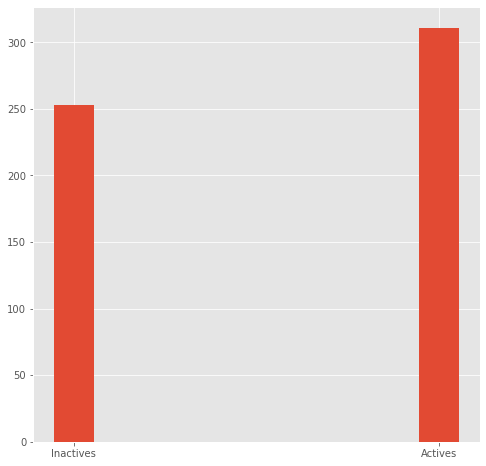

In [180]:
plt.figure(figsize=(8,8))
plt.hist(active, bins=10);
plt.xticks([0.05, 0.95], ["Inactives", "Actives"])
n_active = sum(active)
n_inactive = len(active)-n_active
print(f"Actives {n_active}, {100*n_active/(n_active+n_inactive):.2f}%; Inactives {n_inactive}, {100*n_inactive/(n_active+n_inactive):.2f}%")

In [323]:
def print_metrics(predicted_values, target_values, verbose=True):
    tn, fp, fn, tp = confusion_matrix(target_values, predicted_values >= 0.5).ravel()
    Sn = tp/(tp+fn)
    Sp = tn/(tn+fp)
    precision = tp/(tp+fp)
    ner = (Sn+Sp)/2
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    if verbose:
        print(f"NER: {ner:.3f}, Sensitivity or recall: {Sn:.3f}, Specificity: {Sp:.3f}, Precision: {precision:.3f}, Correctly classified: {accuracy:.3f}, MCC: {mcc:.3f}")
    return [accuracy, mcc]

def plot_confusion(predicted_values, target_values):
    cm = confusion_matrix(target_values, predicted_values >= 0.5)
    f, ax = plt.subplots(1, 1)
    sns.heatmap(cm, annot=True, ax = ax, fmt="g", cmap="Greens")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Inactive', 'Active']); ax.yaxis.set_ticklabels(['Inactive', 'Active'])
    plt.show()
    
def grid_search_SVM(train_data, test_data, train_labels, test_labels, max_gamma=1, min_gamma=0.001, max_C=100, min_C=0.01, n_points=30):
    accuracy = []
    MCCs = []
    C_values = np.geomspace(min_C, max_C, num=n_points)
    gamma_values = np.geomspace(min_gamma, max_gamma, num=n_points)
    for c_val in C_values:
        acc = []
        mcc = []
        for gamma in gamma_values:
            svm = SVC(C=c_val, kernel="rbf", gamma=gamma)
            svm.fit(train_data, train_labels)
            predictions = svm.predict(test_data)
            print(f"C={c_val}, gamma={gamma}")
            vals = print_metrics(predictions, test_labels)
            acc.append(vals[0])
            mcc.append(vals[1])
        accuracy.append(acc)
        MCCs.append(mcc)

    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(MCCs, annot=False, ax = ax, cmap="Greens")
    ax.set_yticklabels(np.round(C_values, 2), rotation=0)
    ax.set_xticklabels(np.round(gamma_values, 2), rotation=90)
    ax.set_ylabel("C value")
    ax.set_xlabel(r"$\gamma$")
    plt.show()

In [161]:
train_data, test_data, train_labels, test_labels = train_test_split(joined_features, active, test_size=0.25, random_state=42, stratify=active)

NER: 0.752, Sensitivity or recall: 0.821, Specificity: 0.683, Precision: 0.762, Correctly classified: 0.759, MCC: 0.510


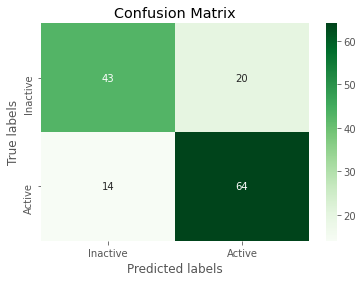

In [263]:
clf = DecisionTreeClassifier(random_state=42) #, class_weight="balanced")
clf.fit(train_data, train_labels)
predictions = clf.predict(test_data)
vals = print_metrics(predictions, test_labels)
plot_confusion(predictions, test_labels)

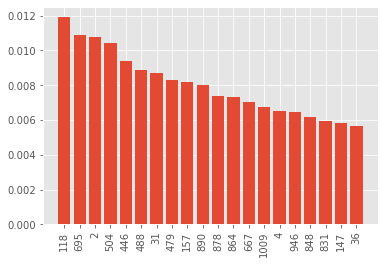

In [256]:
order = np.argsort(clf.feature_importances_)[::-1]
x = np.array(range(len(clf.feature_importances_)))[:20]
plt.bar(x, clf.feature_importances_[order][:20])
plt.xticks(x, order[:20], rotation=90);

NER: 0.779, Sensitivity or recall: 0.859, Specificity: 0.698, Precision: 0.779, Correctly classified: 0.787, MCC: 0.568


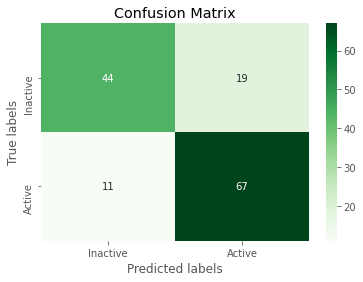

In [278]:
clf = RandomForestClassifier() #, class_weight="balanced")
clf.fit(train_data, train_labels)
predictions = clf.predict(test_data)
vals = print_metrics(predictions, test_labels)
plot_confusion(predictions, test_labels)

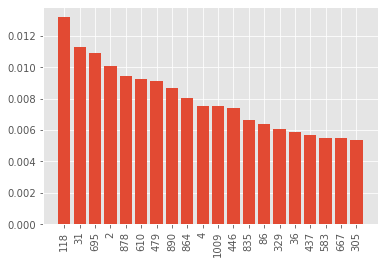

In [279]:
order_RF = np.argsort(clf.feature_importances_)[::-1]
x = np.array(range(len(clf.feature_importances_)))[:20]
plt.bar(x, clf.feature_importances_[order_RF][:20])
plt.xticks(x, order_RF[:20], rotation=90);

In [280]:
# come from highest correlation to labels using chi-2 and mutual information
correlation_best = [864, 2, 835, 878, 305, 118, 504, 284, 157, 446, 31]
best = list(set(correlation_best) & set(order[:20]) & set(order_RF))
print(best)

[864, 2, 878, 118, 504, 157, 446, 31]


In [368]:
def separate_molecules_fp_bit(bit, all_bits):
    positive_ind = []
    negative_ind = []
    for i, bits in enumerate(all_bits):
        if bit in bits:
            positive_ind.append(i)
        else:
            negative_ind.append(i)
    return positive_ind, negative_ind

def plot_sources(source_pos, source_neg):
    colors = list(plt.rcParams['axes.prop_cycle'])
    f, ax = plt.subplots(1, 1)
    width_bar = 0.4
    counts_pos = Counter(source_pos)
    counts_neg = Counter(source_neg)
    ax.bar(-0.2, counts_pos["SARS1"], width=width_bar, label="SARS1", color=colors[0]["color"])
    ax.bar(0.2, counts_pos["SARS2"], width=width_bar, label="SARS2", color=colors[1]["color"])
    ax.bar(0.8, counts_neg["SARS1"], width=width_bar, color=colors[0]["color"])
    ax.bar(1.2, counts_neg["SARS2"], width=width_bar, color=colors[1]["color"])
    plt.legend()
    plt.xticks([0, 1], ["Positive feature", "Negative feature"])
    plt.show()
    
def generate_bit_plots(feature, all_bits, all_mols, all_sources):
    os.makedirs("feature_structures", exist_ok=True)
    pos, neg = separate_molecules_fp_bit(feature, all_bits)
    sources_neg = [all_sources[x] for x in neg]
    sources_pos = [all_sources[x] for x in pos]
    mols_pos = [all_mols[x] for x in pos]
    names_pos = [mol.GetProp("_Name")+"-"+source for mol, source in zip(mols_pos, sources_pos)]
    mols_neg = [all_mols[x] for x in neg]
    names_neg = [mol.GetProp("_Name")+"-"+source for mol, source in zip(mols_neg, sources_neg)]
    tpls = [(all_mols[x],feature,all_bits[x]) for x in pos]
    img = Draw.DrawMorganBits(tpls,molsPerRow=2, legends=names_pos, useSVG=True)
    with open(os.path.join("feature_structures", f'bit_{feature}.svg'), 'w') as f:
        f.write(img.data)

In [268]:
for index in best:
    generate_bit_plots(index, joined_bits, joined_mols, joined_sources)

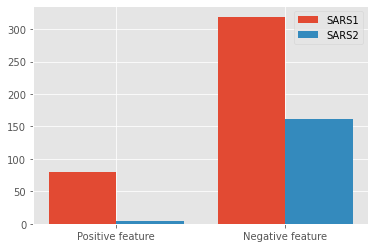

In [258]:
ind_mols_pos, ind_mols_neg = separate_molecules_fp_bit(118, joined_bits)
mols_pos = [joined_mols[x] for x in ind_mols_pos]
names_pos = [mol.GetProp("_Name")+"-"+source for mol, source in zip(mols_pos, sources_pos)]
sources_pos = [joined_sources[x] for x in ind_mols_pos]
mols_neg = [joined_mols[x] for x in ind_mols_neg]
names_neg = [mol.GetProp("_Name")+"-"+source for mol, source in zip(mols_neg, sources_neg)]
sources_neg = [joined_sources[x] for x in ind_mols_neg]
plot_sources(sources_pos, sources_neg)

In [259]:
img=Draw.MolsToGridImage(mols_pos,molsPerRow=4,subImgSize=(400,400),legends=names_pos, maxMols=1e4)
img.save('positives_119.pdf') 
img=Draw.MolsToGridImage(mols_neg,molsPerRow=4,subImgSize=(200,200),legends=names_neg, maxMols=1e4)
img.save('negatives_119.pdf') 

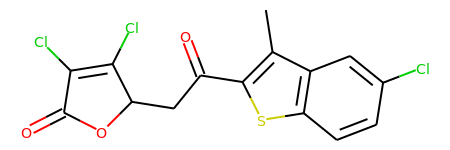

In [260]:
joined_mols[ind_mols_pos[6]]

In [261]:
tpls = [(joined_mols[x],118,joined_bits[x]) for x in ind_mols_pos]
img = Draw.DrawMorganBits(tpls,molsPerRow=2, legends=names_pos, useSVG=True)
# img.save("bit_118.tiff")

In [264]:
with open('bit_118.svg', 'w') as f:
    f.write(img.data)

NER: 0.790, Sensitivity or recall: 0.897, Specificity: 0.683, Precision: 0.778, Correctly classified: 0.801, MCC: 0.600


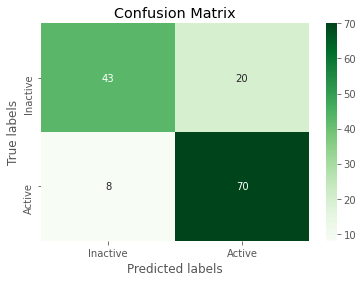

In [46]:
clf = RandomForestClassifier(random_state=42)
clf.fit(train_data, train_labels)
predictions = clf.predict(test_data)
vals = print_metrics(predictions, test_labels)
plot_confusion(predictions, test_labels)

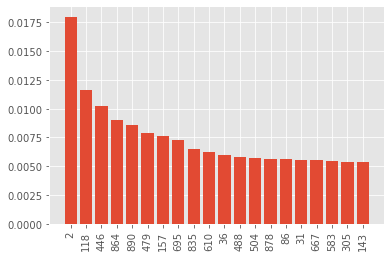

In [47]:
order = np.argsort(clf.feature_importances_)[::-1]
x = np.array(range(len(clf.feature_importances_)))[:20]
plt.bar(x, clf.feature_importances_[order][:20])
plt.xticks(x, order[:20], rotation=90);

We test a similar approach with the SARS2 data set only

In [363]:
active_SARS2 = data_filtered["Is_active"]
train_data2, test_data2, train_labels2, test_labels2 = train_test_split(features_full, active_SARS2, test_size=0.25, random_state=42, stratify=active_SARS2)

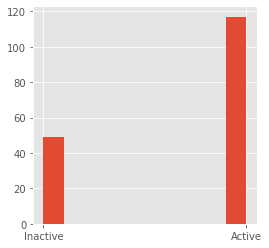

In [364]:
plt.figure(figsize=(4,4))
plt.hist(active_SARS2, bins=10);
plt.xticks([0, 1], ["Inactive", "Active"]);

NER: 0.675, Sensitivity or recall: 0.933, Specificity: 0.417, Precision: 0.800, Correctly classified: 0.786, MCC: 0.424


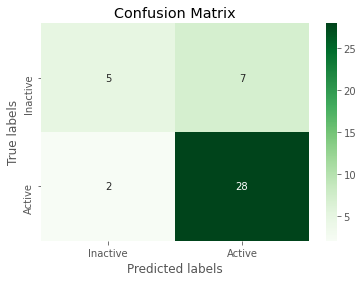

In [368]:
C= 7.8804628
gamm = 0.02807
svm = SVC(C=C, kernel="rbf", gamma=gamm, class_weight="balanced")
svm.fit(train_data2, train_labels2)
predictions = svm.predict(test_data2)
vals = print_metrics(predictions, test_labels2)
plot_confusion(predictions, test_labels2)

Try with the SARS1 data set only

In [257]:
train_data1, test_data1, train_labels1, test_labels1 = train_test_split(features_GHDDI, active_SARS1, test_size=0.25, random_state=42, stratify=active_SARS1)

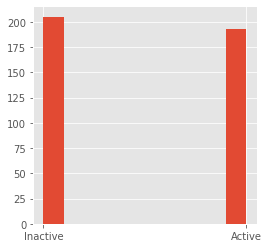

In [258]:
plt.figure(figsize=(4,4))
plt.hist(active_SARS1, bins=10);
plt.xticks([0, 1], ["Inactive", "Active"]);

NER: 0.838, Sensitivity or recall: 0.792, Specificity: 0.885, Precision: 0.864, Correctly classified: 0.840, MCC: 0.681


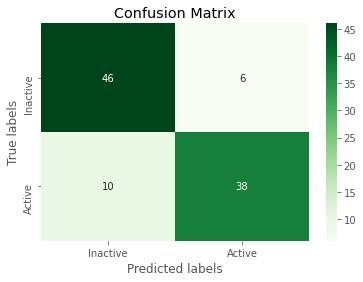

In [369]:
C= 4.17531
gamm = 0.02807
svm = SVC(C=C, kernel="rbf", gamma=gamm, class_weight="balanced")
svm.fit(train_data1, train_labels1)
predictions = svm.predict(test_data1)
vals = print_metrics(predictions, test_labels1)
plot_confusion(predictions, test_labels1)

Train with SARS1, test with SARS2 

NER: 0.535, Sensitivity or recall: 0.111, Specificity: 0.959, Precision: 0.867, Correctly classified: 0.361, MCC: 0.112


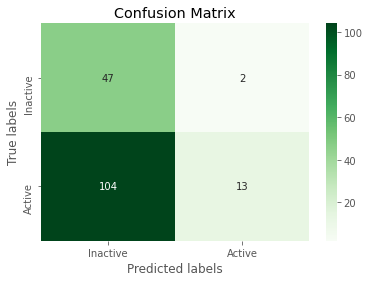

In [370]:
C= 8.53
gamm = 0.05
svm = SVC(C=C, kernel="rbf", gamma=gamm, class_weight="balanced")
svm.fit(features_GHDDI, active_SARS1)
predictions = svm.predict(features_full)
vals = print_metrics(predictions, active_SARS2)
plot_confusion(predictions, active_SARS2)

Similar but adding class weights

NER: 0.535, Sensitivity or recall: 0.111, Specificity: 0.959, Precision: 0.867, Correctly classified: 0.361, MCC: 0.112


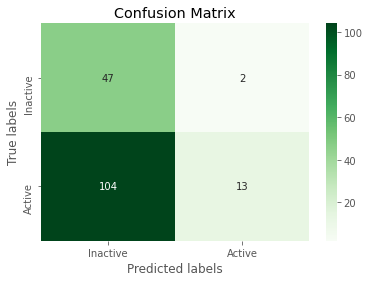

In [355]:
C= 8.53
gamm = 0.05
svm = SVC(C=C, kernel="rbf", gamma=gamm, class_weight="balanced")
svm.fit(features_GHDDI, active_SARS1)
predictions = svm.predict(features_full)
vals = print_metrics(predictions, active_SARS2)
plot_confusion(predictions, active_SARS2)

Train with SARS2, test with SARS1

NER: 0.471, Sensitivity or recall: 0.938, Specificity: 0.005, Precision: 0.470, Correctly classified: 0.457, MCC: -0.161


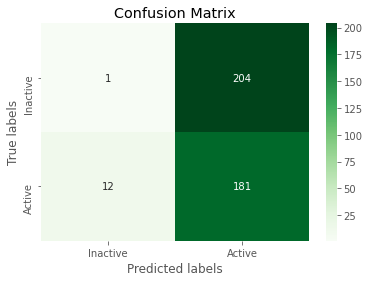

In [261]:
C= 1.172102
gamm = 0.0239
svm = SVC(C=C, kernel="rbf", gamma=gamm)
svm.fit(features_full, active_SARS2)
predictions = svm.predict(features_GHDDI)
vals = print_metrics(predictions, active_SARS1)
plot_confusion(predictions, active_SARS1)

NER: 0.380, Sensitivity or recall: 0.580, Specificity: 0.180, Precision: 0.400, Correctly classified: 0.374, MCC: -0.262


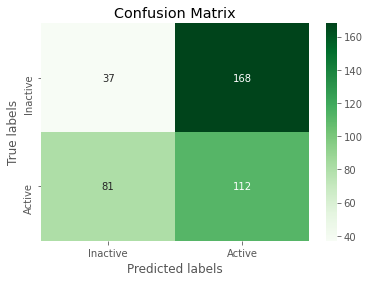

In [356]:
C= 1.172102
gamm = 0.0239
svm = SVC(C=C, kernel="rbf", gamma=gamm, class_weight="balanced")
svm.fit(features_full, active_SARS2)
predictions = svm.predict(features_GHDDI)
vals = print_metrics(predictions, active_SARS1)
plot_confusion(predictions, active_SARS1)

Try 5-fold cross validation with the full data set 

In [322]:
def run_cross_validation(features, labels, folds=5, clf=RandomForestClassifier(random_state=42, class_weight="balanced"), verbose=True):
    skf = StratifiedKFold(n_splits=folds)
    MCCs_train = []
    MCCs_test = []
    accs_train = []
    accs_test = []
    actives_train = []
    actives_test = []
    best_model = None
    best_model_MCC = -2
    best_model_ind = 0
    for i, (train_index, test_index) in enumerate(skf.split(features, labels)):
        train_data, test_data = features[train_index], features[test_index]
        train_labels, test_labels = labels[train_index], labels[test_index]
        actives_train.append(sum(train_labels))
        actives_test.append(sum(test_labels))
        if verbose:
            print(f"Calculating with fold {i}")
        clf.fit(train_data, train_labels)
        pred_train = clf.predict(train_data)
        train_acc, train_mcc = print_metrics(pred_train, train_labels, verbose=verbose)
        predictions = clf.predict(test_data)
        test_acc, test_mcc = print_metrics(predictions, test_labels, verbose=verbose)
        if verbose:
            plot_confusion(predictions, test_labels)
        if test_mcc > best_model_MCC:
            best_model = clf
            best_model_MCC = test_mcc
            best_model_ind = i
        MCCs_train.append(train_mcc)
        MCCs_test.append(test_mcc)
        accs_train.append(train_acc)
        accs_test.append(test_acc)
    if verbose:
        print(f"Best model was obtained from fold {best_model_ind} with MCC {best_model_MCC}")
        for i, (train_index, test_index) in enumerate(skf.split(features, labels)):
            print(f"Calculating with fold {i}")
            train_data, test_data = features[train_index], features[test_index]
            train_labels, test_labels = labels[train_index], labels[test_index]
            predictions = best_model.predict(test_data)
            print_metrics(predictions, test_labels)
            plot_confusion(predictions, test_labels)
    return MCCs_train, MCCs_test, accs_train, accs_test, actives_train, actives_test, best_model

def plot_results_CV(MCCs_train, MCCs_test, accs_train, accs_test, actives_train, actives_test):
    fig, ax = plt.subplots(1,3, figsize=(14,6))
    y_min = -0.1+np.nanmin([np.nanmin(accs_train), np.nanmin(accs_test), np.nanmin(MCCs_train), np.nanmin(MCCs_test)])
    y_max = 0.1+np.nanmax([np.nanmax(accs_train), np.nanmax(accs_test), np.nanmax(MCCs_train), np.nanmax(MCCs_test)])
    ax[0].boxplot([accs_train, accs_test], labels=["Training", "Testing"])
    ax[1].boxplot([MCCs_train, MCCs_test], labels=["Training", "Testing"])
    ax[2].boxplot([actives_train, actives_test], labels=["Training", "Testing"])
    ax[0].set_ylim(top=y_max, bottom=y_min)
    ax[1].set_ylim(top=y_max, bottom=y_min)
    ax[0].set_ylabel("Accuracy")
    ax[1].set_ylabel("MCC")
    ax[2].set_ylabel("Actives proportion")

Calculating with fold 0
NER: 0.998, Sensitivity or recall: 0.996, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.998, MCC: 0.996
NER: 0.578, Sensitivity or recall: 0.875, Specificity: 0.280, Precision: 0.609, Correctly classified: 0.614, MCC: 0.195


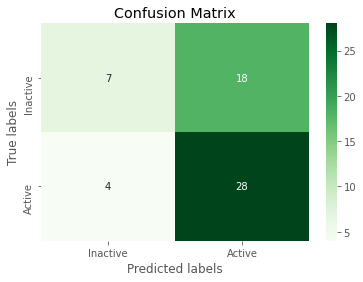

Calculating with fold 1
NER: 0.998, Sensitivity or recall: 0.996, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.998, MCC: 0.996
NER: 0.538, Sensitivity or recall: 0.806, Specificity: 0.269, Precision: 0.568, Correctly classified: 0.561, MCC: 0.090


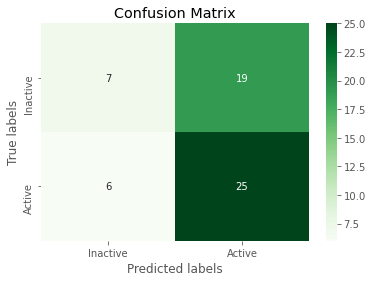

Calculating with fold 2
NER: 0.998, Sensitivity or recall: 0.996, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.998, MCC: 0.996
NER: 0.676, Sensitivity or recall: 0.774, Specificity: 0.577, Precision: 0.686, Correctly classified: 0.684, MCC: 0.359


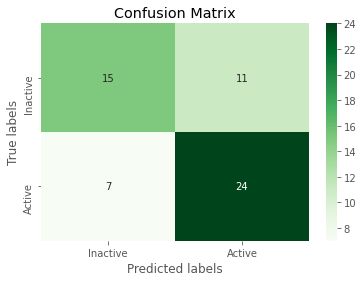

Calculating with fold 3
NER: 0.998, Sensitivity or recall: 0.996, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.998, MCC: 0.996
NER: 0.563, Sensitivity or recall: 0.742, Specificity: 0.385, Precision: 0.590, Correctly classified: 0.579, MCC: 0.136


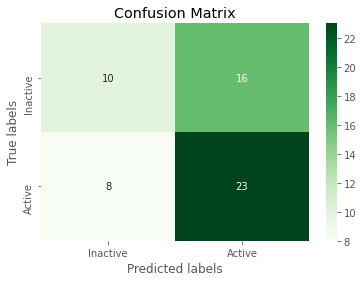

Calculating with fold 4
NER: 0.998, Sensitivity or recall: 0.996, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.998, MCC: 0.996
NER: 0.748, Sensitivity or recall: 0.935, Specificity: 0.560, Precision: 0.725, Correctly classified: 0.768, MCC: 0.545


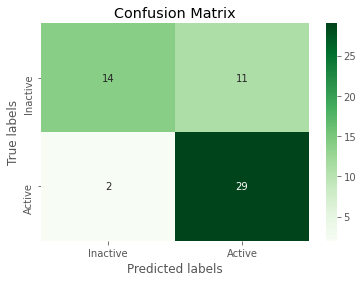

Calculating with fold 5
NER: 1.000, Sensitivity or recall: 1.000, Specificity: 1.000, Precision: 1.000, Correctly classified: 1.000, MCC: 1.000
NER: 0.728, Sensitivity or recall: 0.935, Specificity: 0.520, Precision: 0.707, Correctly classified: 0.750, MCC: 0.511


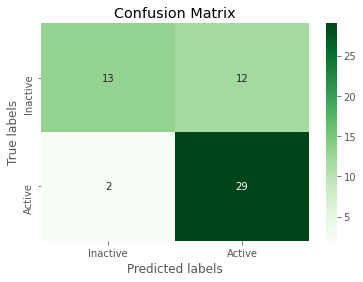

Calculating with fold 6
NER: 0.998, Sensitivity or recall: 0.996, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.998, MCC: 0.996
NER: 0.900, Sensitivity or recall: 1.000, Specificity: 0.800, Precision: 0.861, Correctly classified: 0.911, MCC: 0.830


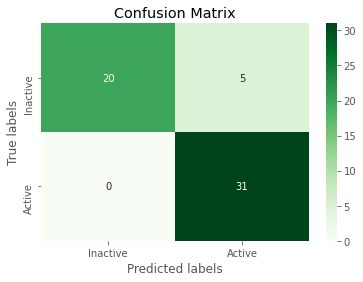

Calculating with fold 7
NER: 0.998, Sensitivity or recall: 0.996, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.998, MCC: 0.996
NER: 0.839, Sensitivity or recall: 0.839, Specificity: 0.840, Precision: 0.867, Correctly classified: 0.839, MCC: 0.677


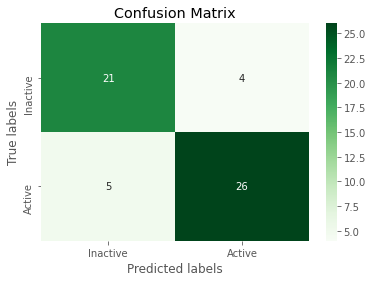

Calculating with fold 8
NER: 0.998, Sensitivity or recall: 0.996, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.998, MCC: 0.996
NER: 0.795, Sensitivity or recall: 0.710, Specificity: 0.880, Precision: 0.880, Correctly classified: 0.786, MCC: 0.590


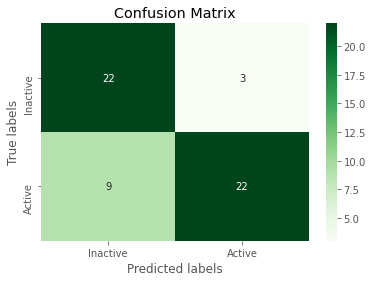

Calculating with fold 9
NER: 1.000, Sensitivity or recall: 1.000, Specificity: 1.000, Precision: 1.000, Correctly classified: 1.000, MCC: 1.000
NER: 0.839, Sensitivity or recall: 0.677, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.821, MCC: 0.696


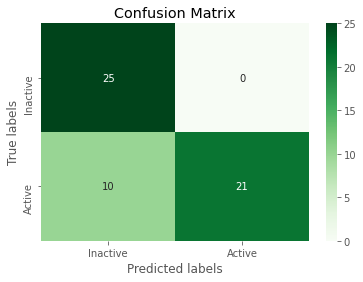

Best model was obtained from fold 6 with MCC 0.8299933065325822
Calculating with fold 0
NER: 1.000, Sensitivity or recall: 1.000, Specificity: 1.000, Precision: 1.000, Correctly classified: 1.000, MCC: 1.000


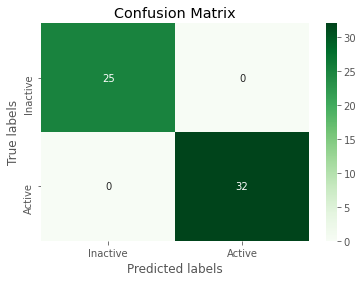

Calculating with fold 1
NER: 1.000, Sensitivity or recall: 1.000, Specificity: 1.000, Precision: 1.000, Correctly classified: 1.000, MCC: 1.000


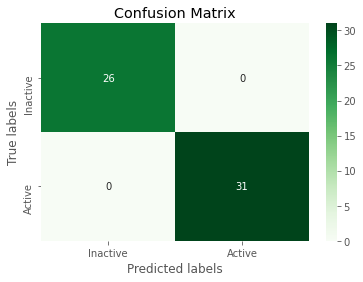

Calculating with fold 2
NER: 1.000, Sensitivity or recall: 1.000, Specificity: 1.000, Precision: 1.000, Correctly classified: 1.000, MCC: 1.000


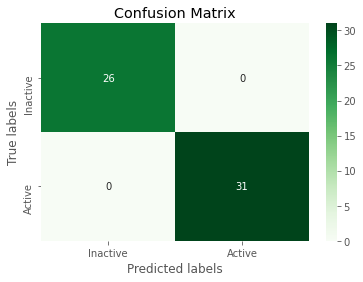

Calculating with fold 3
NER: 1.000, Sensitivity or recall: 1.000, Specificity: 1.000, Precision: 1.000, Correctly classified: 1.000, MCC: 1.000


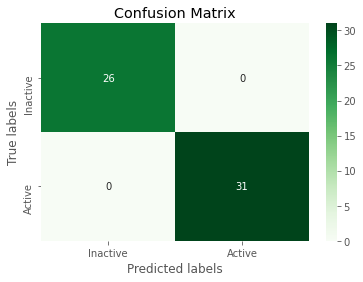

Calculating with fold 4
NER: 1.000, Sensitivity or recall: 1.000, Specificity: 1.000, Precision: 1.000, Correctly classified: 1.000, MCC: 1.000


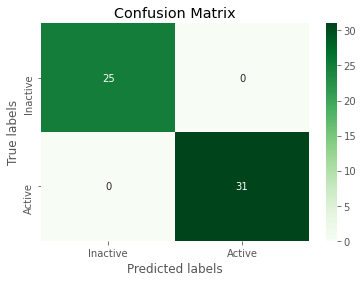

Calculating with fold 5
NER: 1.000, Sensitivity or recall: 1.000, Specificity: 1.000, Precision: 1.000, Correctly classified: 1.000, MCC: 1.000


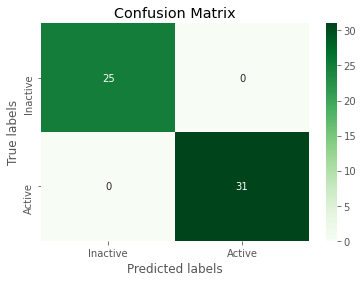

Calculating with fold 6
NER: 1.000, Sensitivity or recall: 1.000, Specificity: 1.000, Precision: 1.000, Correctly classified: 1.000, MCC: 1.000


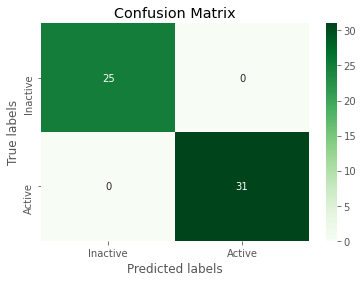

Calculating with fold 7
NER: 1.000, Sensitivity or recall: 1.000, Specificity: 1.000, Precision: 1.000, Correctly classified: 1.000, MCC: 1.000


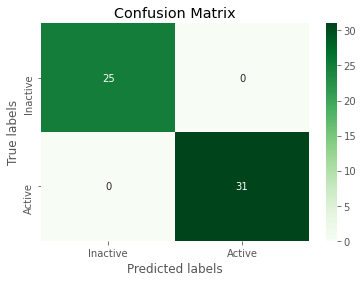

Calculating with fold 8
NER: 1.000, Sensitivity or recall: 1.000, Specificity: 1.000, Precision: 1.000, Correctly classified: 1.000, MCC: 1.000


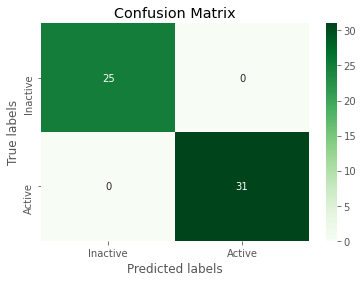

Calculating with fold 9
NER: 0.839, Sensitivity or recall: 0.677, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.821, MCC: 0.696


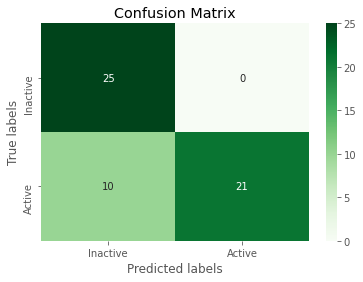

In [313]:
MCC_train_all, MCC_test_all, acc_train_all, acc_test_all, actives_train_all, actives_test_all, opt_model_all = run_cross_validation(joined_features, active, folds=10)

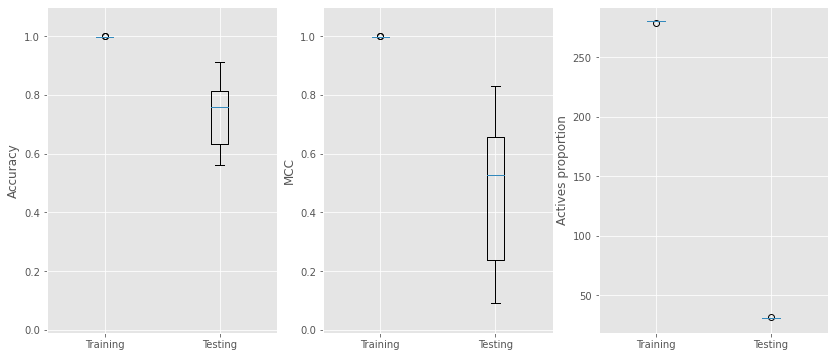

In [314]:
plot_results_CV(MCC_train_all, MCC_test_all, acc_train_all, acc_test_all, actives_train_all, actives_test_all)

NER: 0.984, Sensitivity or recall: 0.968, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.982, MCC: 0.965


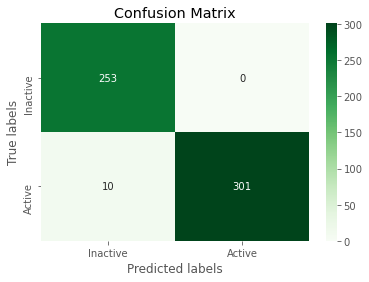

In [315]:
pred_full = opt_model_all.predict(joined_features)
print_metrics(pred_full, active)
plot_confusion(pred_full, active)

In [57]:
percentiles = list(range(1,101,5))
n_features = []
MCCs = []
accs = []
skf = StratifiedKFold(n_splits=10)
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    transform_features = feat_select.fit_transform(joined_features, active)
    n_features.append(transform_features.shape[1])
    mcc_CV = []
    acc_CV = []
    for i, (train_index, test_index) in enumerate(skf.split(transform_features, active)):
        train_data, test_data = transform_features[train_index], transform_features[test_index]
        train_labels, test_labels = active[train_index], active[test_index]
        print(f"Calculating with fold {i}, percentile {percentile}")
        clf = RandomForestClassifier(random_state=42)
        clf.fit(train_data, train_labels)
        predictions = clf.predict(test_data)
        test_acc, test_mcc = print_metrics(predictions, test_labels)
        mcc_CV.append(test_mcc)
        acc_CV.append(test_acc)
    MCCs.append(mcc_CV)
    accs.append(acc_CV)

Calculating with fold 0, percentile 1
NER: 0.490, Sensitivity or recall: 0.903, Specificity: 0.077, Precision: 0.538, Correctly classified: 0.526, MCC: -0.035
Calculating with fold 1, percentile 1
NER: 0.551, Sensitivity or recall: 0.871, Specificity: 0.231, Precision: 0.574, Correctly classified: 0.579, MCC: 0.133
Calculating with fold 2, percentile 1
NER: 0.539, Sensitivity or recall: 0.839, Specificity: 0.240, Precision: 0.578, Correctly classified: 0.571, MCC: 0.098
Calculating with fold 3, percentile 1
NER: 0.467, Sensitivity or recall: 0.774, Specificity: 0.160, Precision: 0.533, Correctly classified: 0.500, MCC: -0.082
Calculating with fold 4, percentile 1
NER: 0.524, Sensitivity or recall: 0.968, Specificity: 0.080, Precision: 0.566, Correctly classified: 0.571, MCC: 0.105
Calculating with fold 5, percentile 1
NER: 0.608, Sensitivity or recall: 0.935, Specificity: 0.280, Precision: 0.617, Correctly classified: 0.643, MCC: 0.292
Calculating with fold 6, percentile 1
NER: 0.792, 

NER: 0.499, Sensitivity or recall: 0.677, Specificity: 0.320, Precision: 0.553, Correctly classified: 0.518, MCC: -0.003
Calculating with fold 4, percentile 26
NER: 0.692, Sensitivity or recall: 0.903, Specificity: 0.480, Precision: 0.683, Correctly classified: 0.714, MCC: 0.430
Calculating with fold 5, percentile 26
NER: 0.768, Sensitivity or recall: 0.935, Specificity: 0.600, Precision: 0.744, Correctly classified: 0.786, MCC: 0.579
Calculating with fold 6, percentile 26
NER: 0.864, Sensitivity or recall: 0.968, Specificity: 0.760, Precision: 0.833, Correctly classified: 0.875, MCC: 0.755
Calculating with fold 7, percentile 26
NER: 0.872, Sensitivity or recall: 0.903, Specificity: 0.840, Precision: 0.875, Correctly classified: 0.875, MCC: 0.747
Calculating with fold 8, percentile 26
NER: 0.723, Sensitivity or recall: 0.645, Specificity: 0.800, Precision: 0.800, Correctly classified: 0.714, MCC: 0.445
Calculating with fold 9, percentile 26
NER: 0.881, Sensitivity or recall: 0.800, Spe

NER: 0.748, Sensitivity or recall: 0.935, Specificity: 0.560, Precision: 0.725, Correctly classified: 0.768, MCC: 0.545
Calculating with fold 6, percentile 51
NER: 0.864, Sensitivity or recall: 0.968, Specificity: 0.760, Precision: 0.833, Correctly classified: 0.875, MCC: 0.755
Calculating with fold 7, percentile 51
NER: 0.872, Sensitivity or recall: 0.903, Specificity: 0.840, Precision: 0.875, Correctly classified: 0.875, MCC: 0.747
Calculating with fold 8, percentile 51
NER: 0.743, Sensitivity or recall: 0.645, Specificity: 0.840, Precision: 0.833, Correctly classified: 0.732, MCC: 0.487
Calculating with fold 9, percentile 51
NER: 0.883, Sensitivity or recall: 0.767, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.875, MCC: 0.777
Calculating with fold 0, percentile 56
NER: 0.602, Sensitivity or recall: 0.935, Specificity: 0.269, Precision: 0.604, Correctly classified: 0.632, MCC: 0.280
Calculating with fold 1, percentile 56
NER: 0.557, Sensitivity or recall: 0.806, Spec

NER: 0.868, Sensitivity or recall: 0.935, Specificity: 0.800, Precision: 0.853, Correctly classified: 0.875, MCC: 0.749
Calculating with fold 8, percentile 76
NER: 0.739, Sensitivity or recall: 0.677, Specificity: 0.800, Precision: 0.808, Correctly classified: 0.732, MCC: 0.476
Calculating with fold 9, percentile 76
NER: 0.867, Sensitivity or recall: 0.733, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.857, MCC: 0.749
Calculating with fold 0, percentile 81
NER: 0.605, Sensitivity or recall: 0.903, Specificity: 0.308, Precision: 0.609, Correctly classified: 0.632, MCC: 0.266
Calculating with fold 1, percentile 81
NER: 0.592, Sensitivity or recall: 0.839, Specificity: 0.346, Precision: 0.605, Correctly classified: 0.614, MCC: 0.214
Calculating with fold 2, percentile 81
NER: 0.667, Sensitivity or recall: 0.774, Specificity: 0.560, Precision: 0.686, Correctly classified: 0.679, MCC: 0.343
Calculating with fold 3, percentile 81
NER: 0.515, Sensitivity or recall: 0.710, Spec

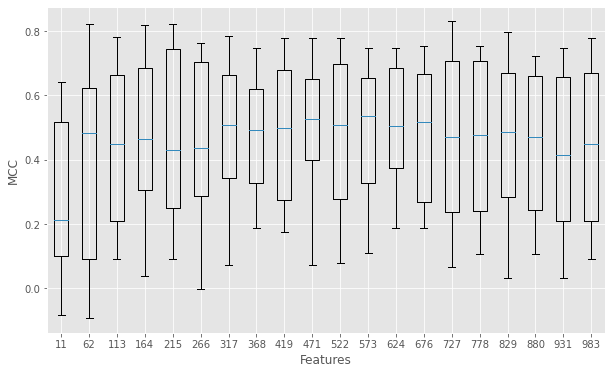

In [58]:
plt.figure(figsize=(10, 6))
plt.boxplot(MCCs, labels=n_features)
plt.ylabel("MCC")
plt.xlabel("Features");

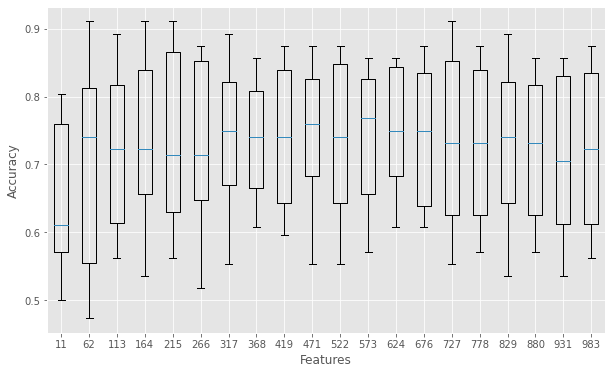

In [59]:
plt.figure(figsize=(10, 6))
plt.boxplot(accs, labels=n_features)
plt.ylabel("Accuracy")
plt.xlabel("Features");

We use now cross validation with the SARS2 set only and then use SARS1 as test set

Calculating with fold 0
NER: 1.000, Sensitivity or recall: 1.000, Specificity: 1.000, Precision: 1.000, Correctly classified: 1.000, MCC: 1.000
NER: 0.550, Sensitivity or recall: 1.000, Specificity: 0.100, Precision: 0.727, Correctly classified: 0.735, MCC: 0.270


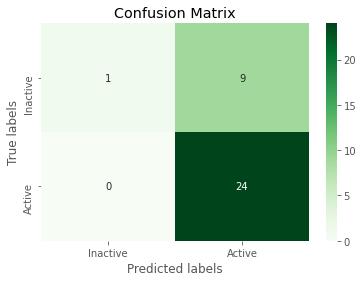

Calculating with fold 1
NER: 1.000, Sensitivity or recall: 1.000, Specificity: 1.000, Precision: 1.000, Correctly classified: 1.000, MCC: 1.000
NER: 0.604, Sensitivity or recall: 0.875, Specificity: 0.333, Precision: 0.778, Correctly classified: 0.727, MCC: 0.241


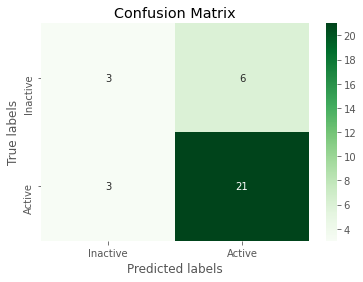

Calculating with fold 2
NER: 1.000, Sensitivity or recall: 1.000, Specificity: 1.000, Precision: 1.000, Correctly classified: 1.000, MCC: 1.000
NER: 0.528, Sensitivity or recall: 0.957, Specificity: 0.100, Precision: 0.710, Correctly classified: 0.697, MCC: 0.109


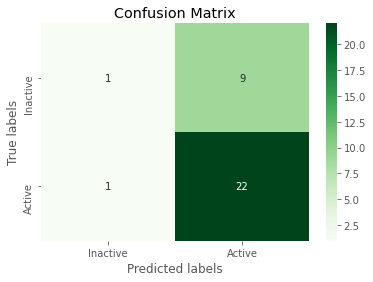

Calculating with fold 3
NER: 1.000, Sensitivity or recall: 1.000, Specificity: 1.000, Precision: 1.000, Correctly classified: 1.000, MCC: 1.000
NER: 0.607, Sensitivity or recall: 0.913, Specificity: 0.300, Precision: 0.750, Correctly classified: 0.727, MCC: 0.273


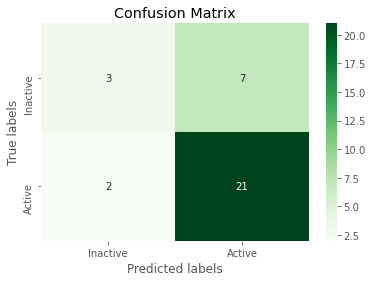

Calculating with fold 4
NER: 1.000, Sensitivity or recall: 1.000, Specificity: 1.000, Precision: 1.000, Correctly classified: 1.000, MCC: 1.000
NER: 0.491, Sensitivity or recall: 0.783, Specificity: 0.200, Precision: 0.692, Correctly classified: 0.606, MCC: -0.020


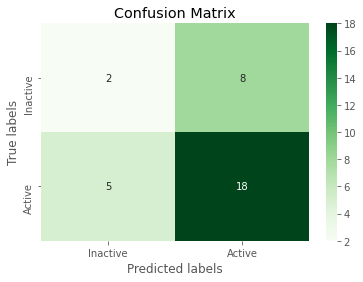

Best model was obtained from fold 3 with MCC 0.2730663241619229
Calculating with fold 0
NER: 1.000, Sensitivity or recall: 1.000, Specificity: 1.000, Precision: 1.000, Correctly classified: 1.000, MCC: 1.000


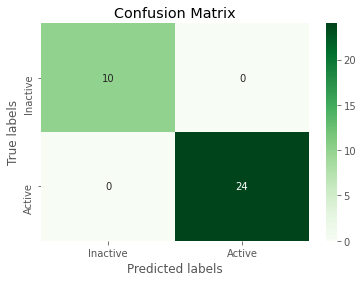

Calculating with fold 1
NER: 1.000, Sensitivity or recall: 1.000, Specificity: 1.000, Precision: 1.000, Correctly classified: 1.000, MCC: 1.000


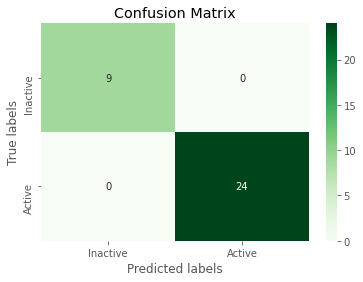

Calculating with fold 2
NER: 0.950, Sensitivity or recall: 1.000, Specificity: 0.900, Precision: 0.958, Correctly classified: 0.970, MCC: 0.929


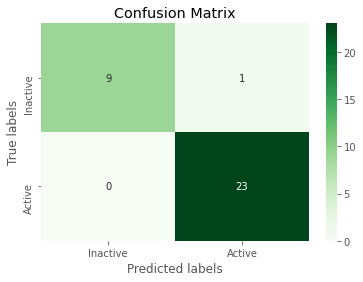

Calculating with fold 3
NER: 0.607, Sensitivity or recall: 0.913, Specificity: 0.300, Precision: 0.750, Correctly classified: 0.727, MCC: 0.273


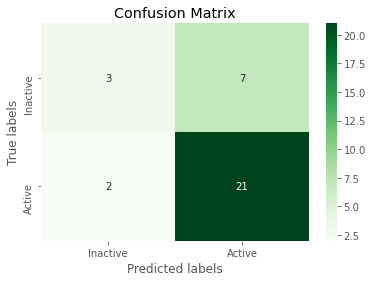

Calculating with fold 4
NER: 0.928, Sensitivity or recall: 0.957, Specificity: 0.900, Precision: 0.957, Correctly classified: 0.939, MCC: 0.857


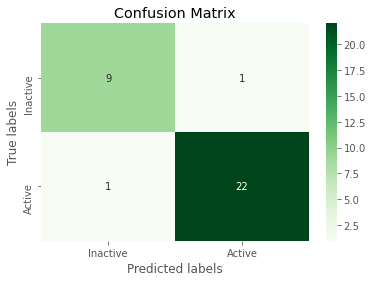

In [63]:
# features_full, features_GHDDI, active_SARS2, active_SARS1
MCC_train12, MCC_test12, acc_train12, acc_test12, actives_train12, actives_test12, opt_model_SARS2 = run_cross_validation(features_full, active_SARS2, folds=5, class_weights="balanced")

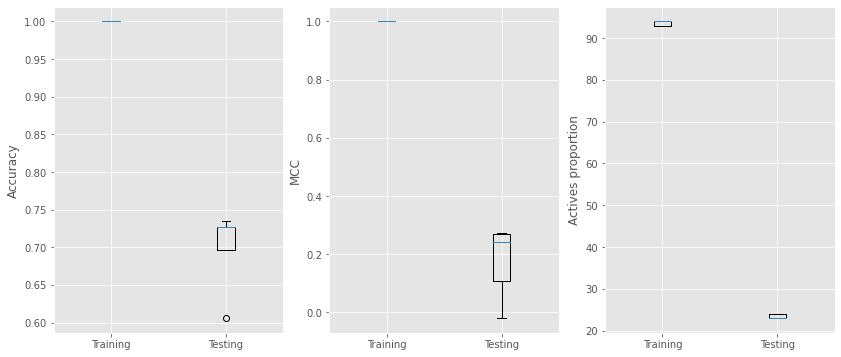

In [64]:
plot_results_CV(MCC_train12, MCC_test12, acc_train12, acc_test12, actives_train12, actives_test12)

NER: 0.468, Sensitivity or recall: 0.891, Specificity: 0.044, Precision: 0.467, Correctly classified: 0.455, MCC: -0.123


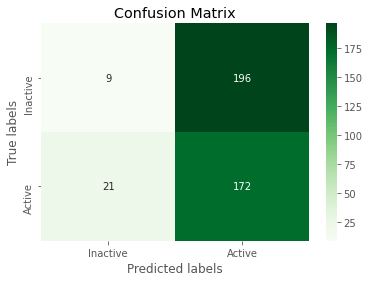

In [67]:
pred = opt_model_SARS2.predict(features_GHDDI)
print_metrics(pred, active_SARS1)
plot_confusion(pred, active_SARS1)

And use CV with SARS1 to test with SARS 2

Calculating with fold 0
NER: 0.997, Sensitivity or recall: 1.000, Specificity: 0.995, Precision: 0.994, Correctly classified: 0.997, MCC: 0.994
NER: 0.550, Sensitivity or recall: 0.250, Specificity: 0.850, Precision: 0.625, Correctly classified: 0.550, MCC: 0.125


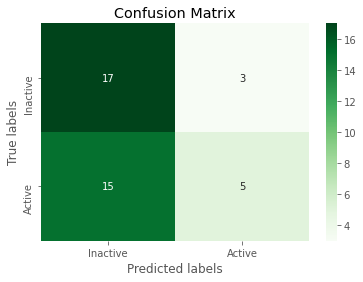

Calculating with fold 1
NER: 0.997, Sensitivity or recall: 0.994, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.997, MCC: 0.994
NER: 0.125, Sensitivity or recall: 0.150, Specificity: 0.100, Precision: 0.143, Correctly classified: 0.125, MCC: -0.751


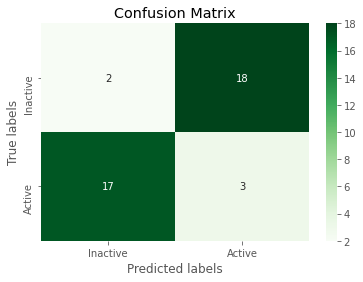

Calculating with fold 2
NER: 0.997, Sensitivity or recall: 0.994, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.997, MCC: 0.994
NER: 0.100, Sensitivity or recall: 0.200, Specificity: 0.000, Precision: 0.167, Correctly classified: 0.100, MCC: -0.816


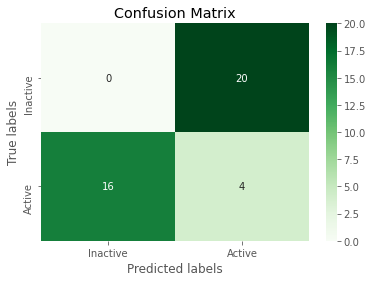

Calculating with fold 3
NER: 0.997, Sensitivity or recall: 1.000, Specificity: 0.995, Precision: 0.994, Correctly classified: 0.997, MCC: 0.994
NER: 0.079, Sensitivity or recall: 0.158, Specificity: 0.000, Precision: 0.125, Correctly classified: 0.075, MCC: -0.858


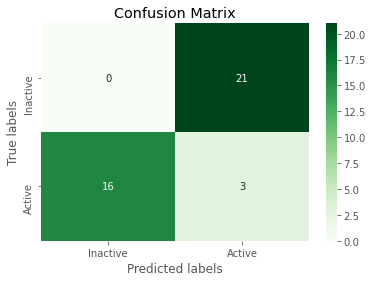

Calculating with fold 4
NER: 1.000, Sensitivity or recall: 1.000, Specificity: 1.000, Precision: 1.000, Correctly classified: 1.000, MCC: 1.000
NER: 0.155, Sensitivity or recall: 0.263, Specificity: 0.048, Precision: 0.200, Correctly classified: 0.150, MCC: -0.711


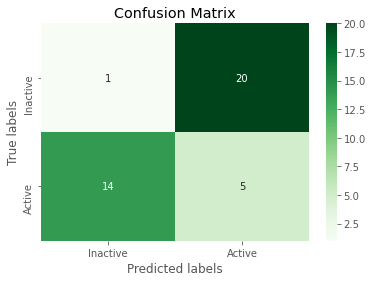

Calculating with fold 5
NER: 0.997, Sensitivity or recall: 0.994, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.997, MCC: 0.994
NER: 0.179, Sensitivity or recall: 0.263, Specificity: 0.095, Precision: 0.208, Correctly classified: 0.175, MCC: -0.654


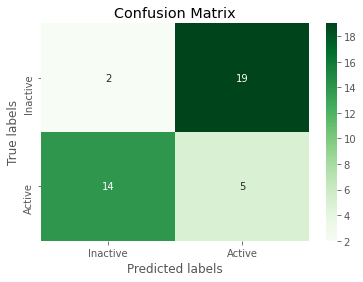

Calculating with fold 6
NER: 0.997, Sensitivity or recall: 0.994, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.997, MCC: 0.994
NER: 0.026, Sensitivity or recall: 0.053, Specificity: 0.000, Precision: 0.045, Correctly classified: 0.025, MCC: -0.951


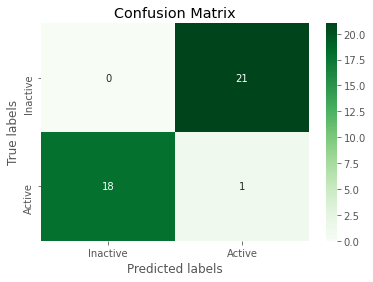

Calculating with fold 7
NER: 0.997, Sensitivity or recall: 0.994, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.997, MCC: 0.994
NER: 0.201, Sensitivity or recall: 0.211, Specificity: 0.190, Precision: 0.190, Correctly classified: 0.200, MCC: -0.599


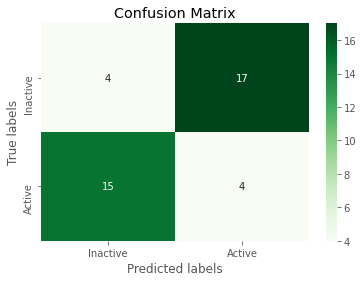

Calculating with fold 8
NER: 0.997, Sensitivity or recall: 0.994, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.997, MCC: 0.994
NER: 0.545, Sensitivity or recall: 0.789, Specificity: 0.300, Precision: 0.517, Correctly classified: 0.538, MCC: 0.102


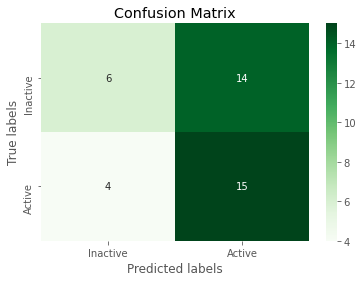

Calculating with fold 9
NER: 1.000, Sensitivity or recall: 1.000, Specificity: 1.000, Precision: 1.000, Correctly classified: 1.000, MCC: 1.000
NER: 0.821, Sensitivity or recall: 0.842, Specificity: 0.800, Precision: 0.800, Correctly classified: 0.821, MCC: 0.642


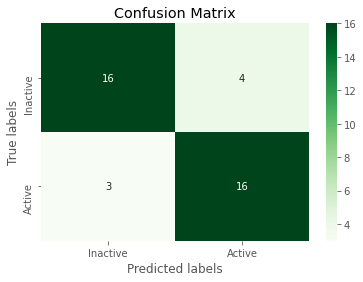

Best model was obtained from fold 9 with MCC 0.6421052631578947
Calculating with fold 0
NER: 0.525, Sensitivity or recall: 0.100, Specificity: 0.950, Precision: 0.667, Correctly classified: 0.525, MCC: 0.095


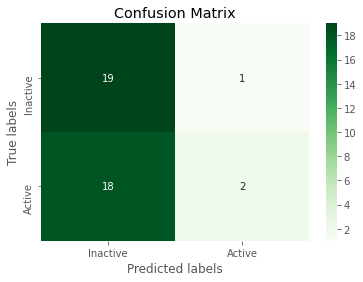

Calculating with fold 1
NER: 0.075, Sensitivity or recall: 0.050, Specificity: 0.100, Precision: 0.053, Correctly classified: 0.075, MCC: -0.851


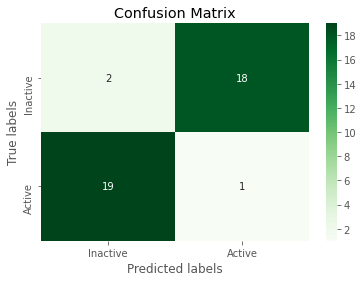

Calculating with fold 2
NER: 0.050, Sensitivity or recall: 0.100, Specificity: 0.000, Precision: 0.091, Correctly classified: 0.050, MCC: -0.905


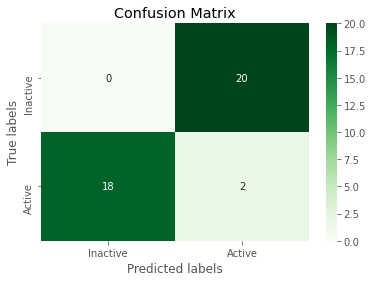

Calculating with fold 3
NER: 0.026, Sensitivity or recall: 0.053, Specificity: 0.000, Precision: 0.045, Correctly classified: 0.025, MCC: -0.951


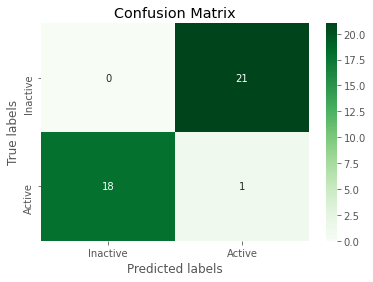

Calculating with fold 4
NER: 0.050, Sensitivity or recall: 0.053, Specificity: 0.048, Precision: 0.048, Correctly classified: 0.050, MCC: -0.900


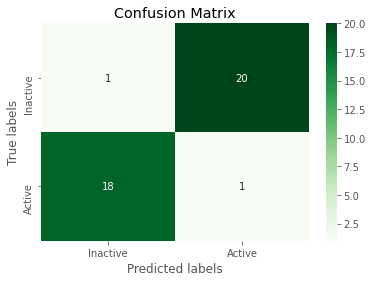

Calculating with fold 5
NER: 0.179, Sensitivity or recall: 0.263, Specificity: 0.095, Precision: 0.208, Correctly classified: 0.175, MCC: -0.654


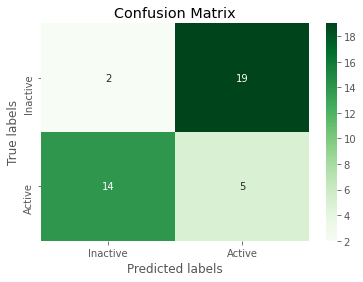

Calculating with fold 6
NER: 0.053, Sensitivity or recall: 0.105, Specificity: 0.000, Precision: 0.087, Correctly classified: 0.050, MCC: -0.904


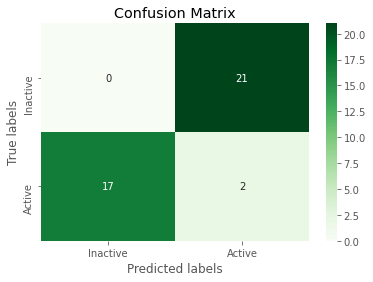

Calculating with fold 7
NER: 0.177, Sensitivity or recall: 0.211, Specificity: 0.143, Precision: 0.182, Correctly classified: 0.175, MCC: -0.649


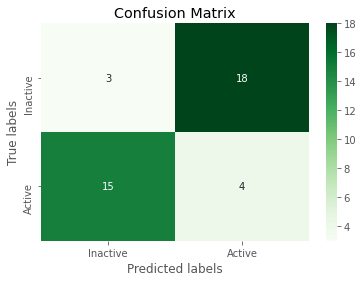

Calculating with fold 8
NER: 0.645, Sensitivity or recall: 0.789, Specificity: 0.500, Precision: 0.600, Correctly classified: 0.641, MCC: 0.302


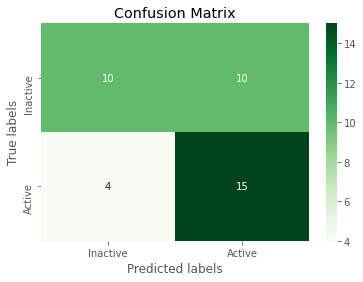

Calculating with fold 9
NER: 0.821, Sensitivity or recall: 0.842, Specificity: 0.800, Precision: 0.800, Correctly classified: 0.821, MCC: 0.642


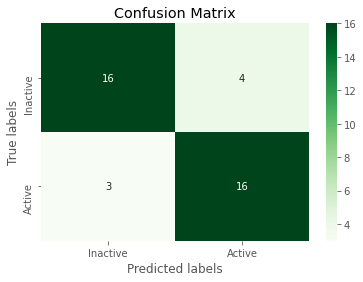

In [69]:
MCC_train12, MCC_test12, acc_train12, acc_test12, actives_train12, actives_test12, opt_model_SARS1 = run_cross_validation(features_GHDDI, active_SARS1, folds=10)

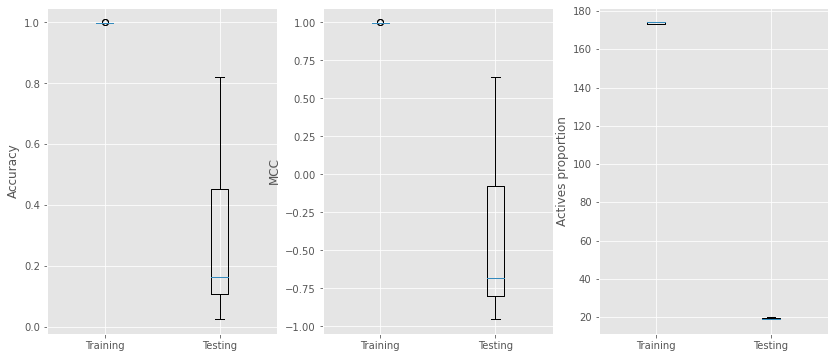

In [70]:
plot_results_CV(MCC_train12, MCC_test12, acc_train12, acc_test12, actives_train12, actives_test12)

NER: 0.477, Sensitivity or recall: 0.077, Specificity: 0.878, Precision: 0.600, Correctly classified: 0.313, MCC: -0.072


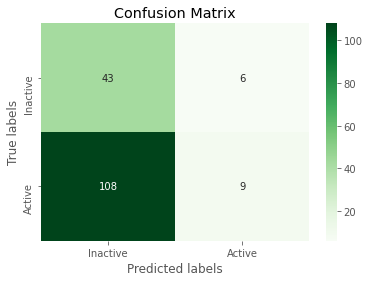

In [71]:
predictions = opt_model_SARS1.predict(features_full)
vals = print_metrics(predictions, active_SARS2)
plot_confusion(predictions, active_SARS2)

We now keep only the features selected from the combination of mutual information, chi-squared and the most important features from a decision tree and random forest

In [337]:
best_features = joined_features[:, best]
best_features_SARS2 = features_full[:, best]
best_features_SARS1 = features_GHDDI[:, best]
print(best_features.shape)

(564, 8)


In [333]:
model = RandomForestClassifier(random_state=42, class_weight="balanced")
MCC_train_all, MCC_test_all, acc_train_all, acc_test_all, actives_train_all, actives_test_all, opt_model_all = run_cross_validation(best_features, active, clf=model, folds=10, verbose=False)

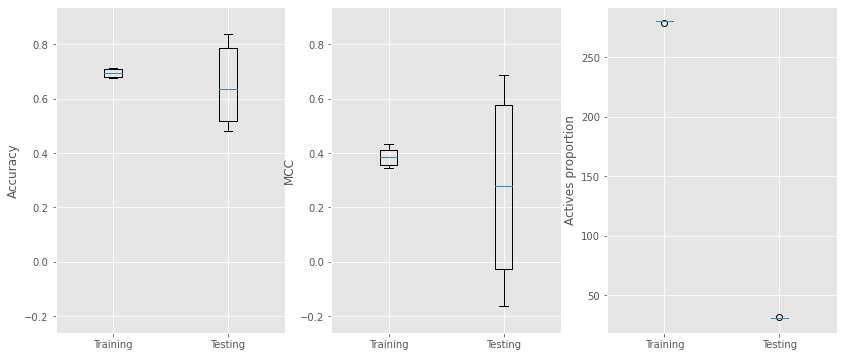

In [334]:
plot_results_CV(MCC_train_all, MCC_test_all, acc_train_all, acc_test_all, actives_train_all, actives_test_all)

In [362]:
model = RandomForestClassifier(random_state=42, n_estimators=1)
MCC_train_all, MCC_test_all, acc_train_all, acc_test_all, actives_train_all, actives_test_all, opt_model_all = run_cross_validation(best_features, active, clf=model, folds=10, verbose=False)

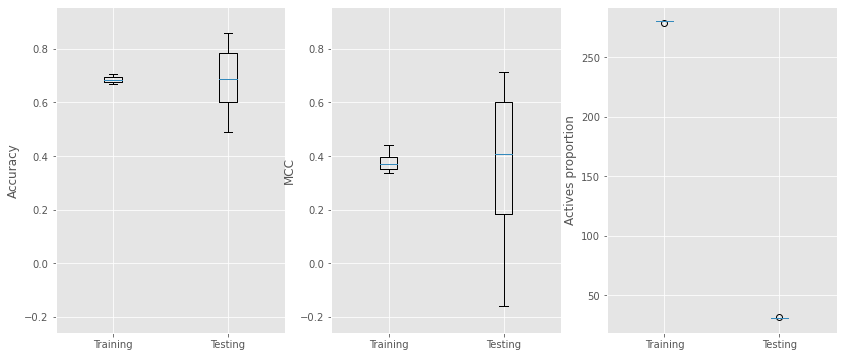

In [363]:
plot_results_CV(MCC_train_all, MCC_test_all, acc_train_all, acc_test_all, actives_train_all, actives_test_all)

In [344]:
model = DecisionTreeClassifier(random_state=42)
MCC_train_all, MCC_test_all, acc_train_all, acc_test_all, actives_train_all, actives_test_all, opt_model_all = run_cross_validation(best_features, active, clf=model, folds=10, verbose=False)

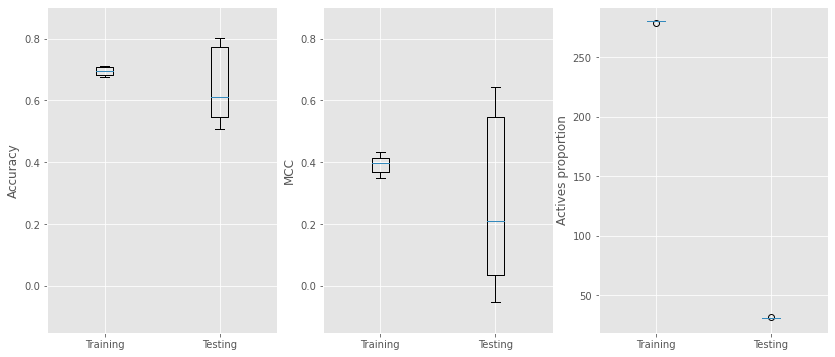

In [345]:
plot_results_CV(MCC_train_all, MCC_test_all, acc_train_all, acc_test_all, actives_train_all, actives_test_all)

Use only SARS2 set

In [364]:
model = RandomForestClassifier(random_state=42, class_weight="balanced")
MCC_train_all, MCC_test_all, acc_train_all, acc_test_all, actives_train_all, actives_test_all, opt_model_all = run_cross_validation(best_features_SARS2, active_SARS2, clf=model, folds=10, verbose=False)

<ipython-input-323-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-323-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


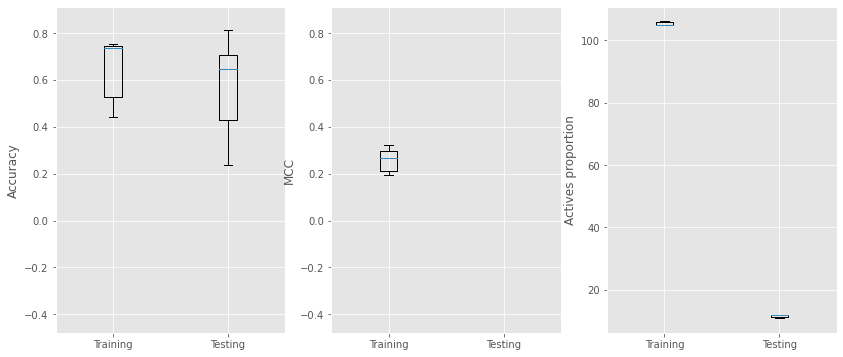

In [365]:
plot_results_CV(MCC_train_all, MCC_test_all, acc_train_all, acc_test_all, actives_train_all, actives_test_all)

Use only SARS1 set

In [366]:
model = RandomForestClassifier(random_state=42, class_weight="balanced")
MCC_train_all, MCC_test_all, acc_train_all, acc_test_all, actives_train_all, actives_test_all, opt_model_all = run_cross_validation(best_features_SARS1, active_SARS1, clf=model, folds=10, verbose=False)

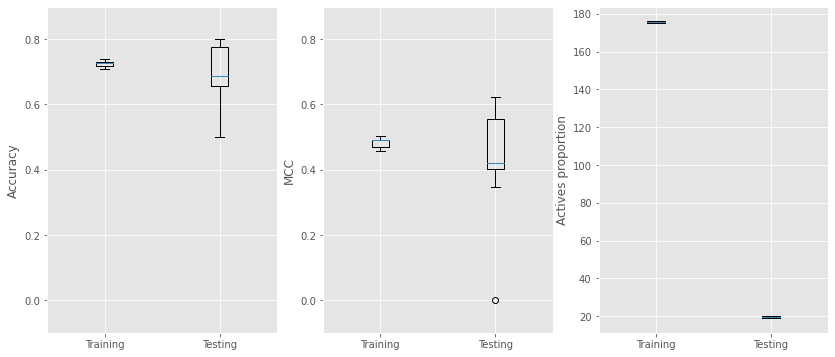

In [367]:
plot_results_CV(MCC_train_all, MCC_test_all, acc_train_all, acc_test_all, actives_train_all, actives_test_all)

In [291]:
n_features = []
MCCs = []
accs = []
skf = StratifiedKFold(n_splits=10)
for n in range(1, len(best)):
    feat_select = SelectKBest(chi2, k=n)
    transform_features = feat_select.fit_transform(best_features, active)
    n_features.append(transform_features.shape[1])
    mcc_CV = []
    acc_CV = []
    for i, (train_index, test_index) in enumerate(skf.split(transform_features, active)):
        train_data, test_data = transform_features[train_index], transform_features[test_index]
        train_labels, test_labels = active[train_index], active[test_index]
        print(f"Calculating with fold {i}, percentile {percentile}")
        clf = DecisionTreeClassifier(random_state=42)
        clf.fit(train_data, train_labels)
        predictions = clf.predict(test_data)
        test_acc, test_mcc = print_metrics(predictions, test_labels)
        mcc_CV.append(test_mcc)
        acc_CV.append(test_acc)
    MCCs.append(mcc_CV)
    accs.append(acc_CV)


Calculating with fold 0, percentile 96
NER: 0.484, Sensitivity or recall: 0.969, Specificity: 0.000, Precision: 0.554, Correctly classified: 0.544, MCC: -0.118
Calculating with fold 1, percentile 96
NER: 0.503, Sensitivity or recall: 0.968, Specificity: 0.038, Precision: 0.545, Correctly classified: 0.544, MCC: 0.017
Calculating with fold 2, percentile 96
NER: 0.538, Sensitivity or recall: 1.000, Specificity: 0.077, Precision: 0.564, Correctly classified: 0.579, MCC: 0.208
Calculating with fold 3, percentile 96
NER: 0.484, Sensitivity or recall: 0.968, Specificity: 0.000, Precision: 0.536, Correctly classified: 0.526, MCC: -0.122
Calculating with fold 4, percentile 96
NER: 0.580, Sensitivity or recall: 1.000, Specificity: 0.160, Precision: 0.596, Correctly classified: 0.625, MCC: 0.309
Calculating with fold 5, percentile 96
NER: 0.700, Sensitivity or recall: 1.000, Specificity: 0.400, Precision: 0.674, Correctly classified: 0.732, MCC: 0.519
Calculating with fold 6, percentile 96
NER: 

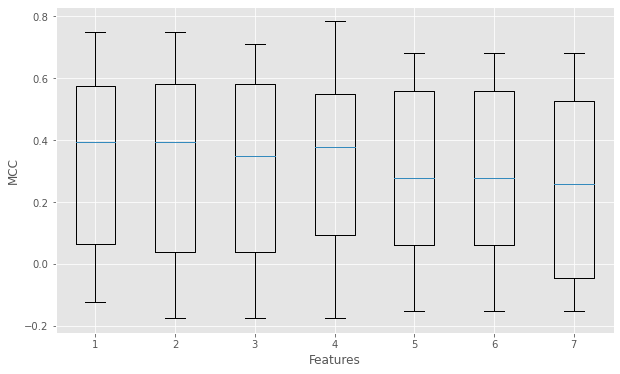

In [292]:
plt.figure(figsize=(10, 6))
plt.boxplot(MCCs, labels=n_features)
plt.ylabel("MCC")
plt.xlabel("Features");

In [293]:
train_data, test_data, train_labels, test_labels = train_test_split(best_features, active, test_size=0.25, random_state=42, stratify=active)

C=0.01, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01, gamma=0.0012689610031679222
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01, gamma=0.0016102620275609393
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01, gamma=0.0020433597178569417
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01, gamma=0.002592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01, gamma=0.0041753189365604
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000

<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid valu

C=0.01, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01, gamma=0.14873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01, gamma=0.18873918221350977
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01, gamma=0.2395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01, gamma=0.3039195382313198
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01, gamma=0.4893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.

<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid valu

C=0.01373823795883263, gamma=0.017433288221999882
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01373823795883263, gamma=0.022122162910704492
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01373823795883263, gamma=0.02807216203941177
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01373823795883263, gamma=0.035622478902624426
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01373823795883263, gamma=0.04520353656360243
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01373823795883263, gamma=0.057361525104486784
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC

<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid valu

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.018873918221350976, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.018873918221350976, gamma=0.0041753189365604
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.018873918221350976, gamma=0.005298316906283708
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.018873918221350976, gamma=0.006723357536499335
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.018873918221350976, gamma=0.008531678524172805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.018873918221350976, gamma=0.010826

<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid valu

C=0.018873918221350976, gamma=0.38566204211634725
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.018873918221350976, gamma=0.4893900918477494
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.018873918221350976, gamma=0.6210169418915616
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.018873918221350976, gamma=0.7880462815669912
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.018873918221350976, gamma=1.0
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.02592943797404667, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.025929437974

<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid valu

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.02592943797404667, gamma=0.04520353656360243
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.02592943797404667, gamma=0.057361525104486784
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.02592943797404667, gamma=0.0727895384398315
NER: 0.571, Sensitivity or recall: 1.000, Specificity: 0.143, Precision: 0.591, Correctly classified: 0.617, MCC: 0.291
C=0.02592943797404667, gamma=0.09236708571873861
NER: 0.611, Sensitivity or recall: 1.000, Specificity: 0.222, Precision: 0.614, Correctly classified: 0.652, MCC: 0.369
C=0.02592943797404667, gamma=0.11721022975334805
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.02592943797404667, gamma=0.1487352107

<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid valu

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.035622478902624426, gamma=0.005298316906283708
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.035622478902624426, gamma=0.006723357536499335
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.035622478902624426, gamma=0.008531678524172805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.035622478902624426, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.035622478902624426, gamma=0.01373823795883263
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.035622478902624426, gamma=0.017433

<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid valu

C=0.04893900918477494, gamma=0.057361525104486784
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.04893900918477494, gamma=0.0727895384398315
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.04893900918477494, gamma=0.09236708571873861
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.04893900918477494, gamma=0.11721022975334805
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.04893900918477494, gamma=0.14873521072935117
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.04893900918477494, gamma=0.18873918221350977
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.66

<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid valu

C=0.06723357536499334, gamma=0.006723357536499335
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.06723357536499334, gamma=0.008531678524172805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.06723357536499334, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.06723357536499334, gamma=0.01373823795883263
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.06723357536499334, gamma=0.017433288221999882
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.06723357536499334, gamma=0.022122162910704492
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MC

<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid valu

C=0.09236708571873861, gamma=0.0012689610031679222
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.09236708571873861, gamma=0.0016102620275609393
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.09236708571873861, gamma=0.0020433597178569417
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.09236708571873861, gamma=0.002592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.09236708571873861, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.09236708571873861, gamma=0.0041753189365604
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553,

<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid valu

C=0.12689610031679222, gamma=0.04520353656360243
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.12689610031679222, gamma=0.057361525104486784
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.12689610031679222, gamma=0.0727895384398315
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.12689610031679222, gamma=0.09236708571873861
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.12689610031679222, gamma=0.11721022975334805
NER: 0.635, Sensitivity or recall: 1.000, Specificity: 0.270, Precision: 0.629, Correctly classified: 0.674, MCC: 0.412
C=0.12689610031679222, gamma=0.14873521072935117
NER: 0.629, Sensitivity or recall: 0.987, Specificity: 0.270, Precision: 0.626, Correctly classified: 0.66

<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid valu

C=0.17433288221999882, gamma=0.010826367338740546
NER: 0.611, Sensitivity or recall: 1.000, Specificity: 0.222, Precision: 0.614, Correctly classified: 0.652, MCC: 0.369
C=0.17433288221999882, gamma=0.01373823795883263
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.17433288221999882, gamma=0.017433288221999882
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.17433288221999882, gamma=0.022122162910704492
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.17433288221999882, gamma=0.02807216203941177
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.17433288221999882, gamma=0.035622478902624426
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 

<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid valu

C=0.2395026619987486, gamma=0.002592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.2395026619987486, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.2395026619987486, gamma=0.0041753189365604
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.2395026619987486, gamma=0.005298316906283708
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.2395026619987486, gamma=0.006723357536499335
NER: 0.603, Sensitivity or recall: 1.000, Specificity: 0.206, Precision: 0.609, Correctly classified: 0.645, MCC: 0.355
C=0.2395026619987486, gamma=0.008531678524172805
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0

<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid valu

C=0.32903445623126676, gamma=0.057361525104486784
NER: 0.629, Sensitivity or recall: 0.987, Specificity: 0.270, Precision: 0.626, Correctly classified: 0.667, MCC: 0.383
C=0.32903445623126676, gamma=0.0727895384398315
NER: 0.629, Sensitivity or recall: 0.987, Specificity: 0.270, Precision: 0.626, Correctly classified: 0.667, MCC: 0.383
C=0.32903445623126676, gamma=0.09236708571873861
NER: 0.629, Sensitivity or recall: 0.987, Specificity: 0.270, Precision: 0.626, Correctly classified: 0.667, MCC: 0.383
C=0.32903445623126676, gamma=0.11721022975334805
NER: 0.629, Sensitivity or recall: 0.987, Specificity: 0.270, Precision: 0.626, Correctly classified: 0.667, MCC: 0.383
C=0.32903445623126676, gamma=0.14873521072935117
NER: 0.622, Sensitivity or recall: 0.974, Specificity: 0.270, Precision: 0.623, Correctly classified: 0.660, MCC: 0.356
C=0.32903445623126676, gamma=0.18873918221350977
NER: 0.630, Sensitivity or recall: 0.974, Specificity: 0.286, Precision: 0.628, Correctly classified: 0.66

<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.4520353656360243, gamma=0.010826367338740546
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.4520353656360243, gamma=0.01373823795883263
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.4520353656360243, gamma=0.017433288221999882
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.4520353656360243, gamma=0.022122162910704492
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.4520353656360243, gamma=0.02807216203941177
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.4520353656360243, gamma=0.035622478902624426
NER: 0.635, Sensitivity or recall: 1.000, Specificity: 0.270, Precision: 0.629, Correctly classified: 0.674,

<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.6210169418915616, gamma=0.0041753189365604
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.6210169418915616, gamma=0.005298316906283708
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.6210169418915616, gamma=0.006723357536499335
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.6210169418915616, gamma=0.008531678524172805
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.6210169418915616, gamma=0.010826367338740546
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.6210169418915616, gamma=0.0137382

<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.8531678524172805, gamma=0.3039195382313198
NER: 0.635, Sensitivity or recall: 0.936, Specificity: 0.333, Precision: 0.635, Correctly classified: 0.667, MCC: 0.345
C=0.8531678524172805, gamma=0.38566204211634725
NER: 0.635, Sensitivity or recall: 0.936, Specificity: 0.333, Precision: 0.635, Correctly classified: 0.667, MCC: 0.345
C=0.8531678524172805, gamma=0.4893900918477494
NER: 0.635, Sensitivity or recall: 0.936, Specificity: 0.333, Precision: 0.635, Correctly classified: 0.667, MCC: 0.345
C=0.8531678524172805, gamma=0.6210169418915616
NER: 0.633, Sensitivity or recall: 0.885, Specificity: 0.381, Precision: 0.639, Correctly classified: 0.660, MCC: 0.312
C=0.8531678524172805, gamma=0.7880462815669912
NER: 0.633, Sensitivity or recall: 0.885, Specificity: 0.381, Precision: 0.639, Correctly classified: 0.660, MCC: 0.312
C=0.8531678524172805, gamma=1.0
NER: 0.639, Sensitivity or recall: 0.897, Specificity: 0.381, Precision: 0.642, Correctly classified: 0.667, MCC: 0.330
C=1.17210229

<ipython-input-160-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=1.1721022975334805, gamma=0.11721022975334805
NER: 0.635, Sensitivity or recall: 0.936, Specificity: 0.333, Precision: 0.635, Correctly classified: 0.667, MCC: 0.345
C=1.1721022975334805, gamma=0.14873521072935117
NER: 0.635, Sensitivity or recall: 0.936, Specificity: 0.333, Precision: 0.635, Correctly classified: 0.667, MCC: 0.345
C=1.1721022975334805, gamma=0.18873918221350977
NER: 0.635, Sensitivity or recall: 0.936, Specificity: 0.333, Precision: 0.635, Correctly classified: 0.667, MCC: 0.345
C=1.1721022975334805, gamma=0.2395026619987486
NER: 0.635, Sensitivity or recall: 0.936, Specificity: 0.333, Precision: 0.635, Correctly classified: 0.667, MCC: 0.345
C=1.1721022975334805, gamma=0.3039195382313198
NER: 0.635, Sensitivity or recall: 0.936, Specificity: 0.333, Precision: 0.635, Correctly classified: 0.667, MCC: 0.345
C=1.1721022975334805, gamma=0.38566204211634725
NER: 0.635, Sensitivity or recall: 0.936, Specificity: 0.333, Precision: 0.635, Correctly classified: 0.667, MCC: 

C=2.212216291070448, gamma=0.022122162910704492
NER: 0.629, Sensitivity or recall: 0.987, Specificity: 0.270, Precision: 0.626, Correctly classified: 0.667, MCC: 0.383
C=2.212216291070448, gamma=0.02807216203941177
NER: 0.622, Sensitivity or recall: 0.974, Specificity: 0.270, Precision: 0.623, Correctly classified: 0.660, MCC: 0.356
C=2.212216291070448, gamma=0.035622478902624426
NER: 0.622, Sensitivity or recall: 0.974, Specificity: 0.270, Precision: 0.623, Correctly classified: 0.660, MCC: 0.356
C=2.212216291070448, gamma=0.04520353656360243
NER: 0.630, Sensitivity or recall: 0.974, Specificity: 0.286, Precision: 0.628, Correctly classified: 0.667, MCC: 0.371
C=2.212216291070448, gamma=0.057361525104486784
NER: 0.632, Sensitivity or recall: 0.962, Specificity: 0.302, Precision: 0.630, Correctly classified: 0.667, MCC: 0.360
C=2.212216291070448, gamma=0.0727895384398315
NER: 0.635, Sensitivity or recall: 0.936, Specificity: 0.333, Precision: 0.635, Correctly classified: 0.667, MCC: 0.

C=4.175318936560401, gamma=0.0041753189365604
NER: 0.629, Sensitivity or recall: 0.987, Specificity: 0.270, Precision: 0.626, Correctly classified: 0.667, MCC: 0.383
C=4.175318936560401, gamma=0.005298316906283708
NER: 0.629, Sensitivity or recall: 0.987, Specificity: 0.270, Precision: 0.626, Correctly classified: 0.667, MCC: 0.383
C=4.175318936560401, gamma=0.006723357536499335
NER: 0.629, Sensitivity or recall: 0.987, Specificity: 0.270, Precision: 0.626, Correctly classified: 0.667, MCC: 0.383
C=4.175318936560401, gamma=0.008531678524172805
NER: 0.629, Sensitivity or recall: 0.987, Specificity: 0.270, Precision: 0.626, Correctly classified: 0.667, MCC: 0.383
C=4.175318936560401, gamma=0.010826367338740546
NER: 0.629, Sensitivity or recall: 0.987, Specificity: 0.270, Precision: 0.626, Correctly classified: 0.667, MCC: 0.383
C=4.175318936560401, gamma=0.01373823795883263
NER: 0.622, Sensitivity or recall: 0.974, Specificity: 0.270, Precision: 0.623, Correctly classified: 0.660, MCC: 0

C=5.736152510448681, gamma=0.4893900918477494
NER: 0.638, Sensitivity or recall: 0.910, Specificity: 0.365, Precision: 0.640, Correctly classified: 0.667, MCC: 0.334
C=5.736152510448681, gamma=0.6210169418915616
NER: 0.638, Sensitivity or recall: 0.910, Specificity: 0.365, Precision: 0.640, Correctly classified: 0.667, MCC: 0.334
C=5.736152510448681, gamma=0.7880462815669912
NER: 0.638, Sensitivity or recall: 0.910, Specificity: 0.365, Precision: 0.640, Correctly classified: 0.667, MCC: 0.334
C=5.736152510448681, gamma=1.0
NER: 0.638, Sensitivity or recall: 0.910, Specificity: 0.365, Precision: 0.640, Correctly classified: 0.667, MCC: 0.334
C=7.880462815669913, gamma=0.001
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=7.880462815669913, gamma=0.0012689610031679222
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=7.880462815669913, gamma=0.

C=10.82636733874054, gamma=0.0727895384398315
NER: 0.635, Sensitivity or recall: 0.936, Specificity: 0.333, Precision: 0.635, Correctly classified: 0.667, MCC: 0.345
C=10.82636733874054, gamma=0.09236708571873861
NER: 0.635, Sensitivity or recall: 0.936, Specificity: 0.333, Precision: 0.635, Correctly classified: 0.667, MCC: 0.345
C=10.82636733874054, gamma=0.11721022975334805
NER: 0.635, Sensitivity or recall: 0.936, Specificity: 0.333, Precision: 0.635, Correctly classified: 0.667, MCC: 0.345
C=10.82636733874054, gamma=0.14873521072935117
NER: 0.641, Sensitivity or recall: 0.949, Specificity: 0.333, Precision: 0.638, Correctly classified: 0.674, MCC: 0.367
C=10.82636733874054, gamma=0.18873918221350977
NER: 0.639, Sensitivity or recall: 0.962, Specificity: 0.317, Precision: 0.636, Correctly classified: 0.674, MCC: 0.375
C=10.82636733874054, gamma=0.2395026619987486
NER: 0.639, Sensitivity or recall: 0.962, Specificity: 0.317, Precision: 0.636, Correctly classified: 0.674, MCC: 0.375


C=20.433597178569418, gamma=0.006723357536499335
NER: 0.638, Sensitivity or recall: 0.974, Specificity: 0.302, Precision: 0.633, Correctly classified: 0.674, MCC: 0.385
C=20.433597178569418, gamma=0.008531678524172805
NER: 0.635, Sensitivity or recall: 0.936, Specificity: 0.333, Precision: 0.635, Correctly classified: 0.667, MCC: 0.345
C=20.433597178569418, gamma=0.010826367338740546
NER: 0.635, Sensitivity or recall: 0.936, Specificity: 0.333, Precision: 0.635, Correctly classified: 0.667, MCC: 0.345
C=20.433597178569418, gamma=0.01373823795883263
NER: 0.635, Sensitivity or recall: 0.936, Specificity: 0.333, Precision: 0.635, Correctly classified: 0.667, MCC: 0.345
C=20.433597178569418, gamma=0.017433288221999882
NER: 0.635, Sensitivity or recall: 0.936, Specificity: 0.333, Precision: 0.635, Correctly classified: 0.667, MCC: 0.345
C=20.433597178569418, gamma=0.022122162910704492
NER: 0.635, Sensitivity or recall: 0.936, Specificity: 0.333, Precision: 0.635, Correctly classified: 0.667

C=38.56620421163472, gamma=0.0012689610031679222
NER: 0.629, Sensitivity or recall: 0.987, Specificity: 0.270, Precision: 0.626, Correctly classified: 0.667, MCC: 0.383
C=38.56620421163472, gamma=0.0016102620275609393
NER: 0.622, Sensitivity or recall: 0.974, Specificity: 0.270, Precision: 0.623, Correctly classified: 0.660, MCC: 0.356
C=38.56620421163472, gamma=0.0020433597178569417
NER: 0.622, Sensitivity or recall: 0.974, Specificity: 0.270, Precision: 0.623, Correctly classified: 0.660, MCC: 0.356
C=38.56620421163472, gamma=0.002592943797404667
NER: 0.630, Sensitivity or recall: 0.974, Specificity: 0.286, Precision: 0.628, Correctly classified: 0.667, MCC: 0.371
C=38.56620421163472, gamma=0.0032903445623126675
NER: 0.638, Sensitivity or recall: 0.974, Specificity: 0.302, Precision: 0.633, Correctly classified: 0.674, MCC: 0.385
C=38.56620421163472, gamma=0.0041753189365604
NER: 0.638, Sensitivity or recall: 0.974, Specificity: 0.302, Precision: 0.633, Correctly classified: 0.674, M

C=72.78953843983146, gamma=0.010826367338740546
NER: 0.635, Sensitivity or recall: 0.936, Specificity: 0.333, Precision: 0.635, Correctly classified: 0.667, MCC: 0.345
C=72.78953843983146, gamma=0.01373823795883263
NER: 0.635, Sensitivity or recall: 0.936, Specificity: 0.333, Precision: 0.635, Correctly classified: 0.667, MCC: 0.345
C=72.78953843983146, gamma=0.017433288221999882
NER: 0.635, Sensitivity or recall: 0.936, Specificity: 0.333, Precision: 0.635, Correctly classified: 0.667, MCC: 0.345
C=72.78953843983146, gamma=0.022122162910704492
NER: 0.635, Sensitivity or recall: 0.936, Specificity: 0.333, Precision: 0.635, Correctly classified: 0.667, MCC: 0.345
C=72.78953843983146, gamma=0.02807216203941177
NER: 0.635, Sensitivity or recall: 0.936, Specificity: 0.333, Precision: 0.635, Correctly classified: 0.667, MCC: 0.345
C=72.78953843983146, gamma=0.035622478902624426
NER: 0.635, Sensitivity or recall: 0.936, Specificity: 0.333, Precision: 0.635, Correctly classified: 0.667, MCC: 

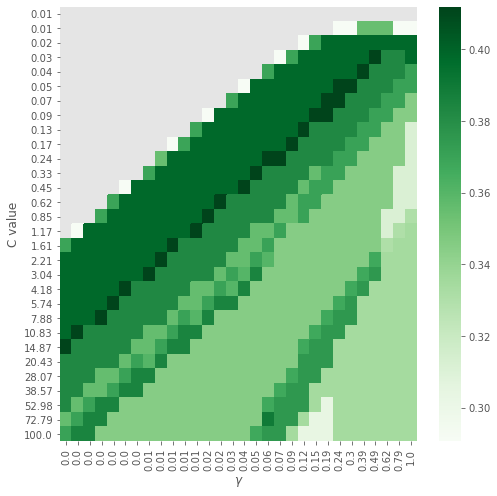

In [294]:
grid_search_SVM(train_data, test_data, train_labels, test_labels)

In [328]:
C=3.039195382313198
gamma=0.005298316906283708
svm_obj = SVC(C=C, kernel="rbf", gamma=gamma, class_weight="balanced")
MCC_train_all, MCC_test_all, acc_train_all, acc_test_all, actives_train_all, actives_test_all, opt_model_all = run_cross_validation(best_features, active, folds=10, clf=svm_obj, verbose=False)

<ipython-input-323-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-323-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


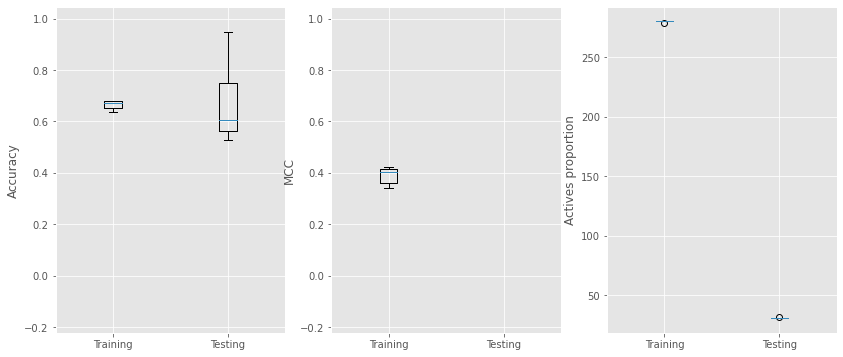

In [329]:
plot_results_CV(MCC_train_all, MCC_test_all, acc_train_all, acc_test_all, actives_train_all, actives_test_all)